In [40]:
#!/usr/bin/env python3

# add the path to the folder above, hardcoded
import sys
pathhere = "/home/luke/mujoco-devel/rl/"
sys.path.insert(0, pathhere)

from env.MjEnv import MjEnv
import numpy as np
from matplotlib import pyplot as plt
import pickle

# increase matplotlib resolution
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

In [41]:
# get the test data
testdatapath = "/home/luke/gripper-ros/test_data/palm_vs_no_palm"
test_names = "{0}_E{1}_{2}_YCB"
palms = ["no_palm", "palm"]
stiffnesses = [1, 2, 3]
fingers = [45, 60, 75, 90]

# create modelsaver instance
from ModelSaver import ModelSaver
directory = ""#"pb4_tests_apr23" # ""
saver = ModelSaver(testdatapath)

# get test data class
pathtestclass = "/home/luke/gripper-ros/src/rl/gripper_dqn/scripts/"
sys.path.insert(0, pathtestclass)
from grasp_test_data import GraspTestData, set_palm_frc_threshold, set_X_frc_threshold, set_Y_frc_threshold
data_explorer = GraspTestData()
set_palm_frc_threshold(10.0)
set_X_frc_threshold(10.0)
set_Y_frc_threshold(10.0)

# WATCH OUT FOR THIS SETTING
data_explorer.add_palm_start_force = False

In [42]:
# load the results from all of the tests
results = [
[
    [
      [] for f in range(len(fingers))
    ] for s in range(len(stiffnesses))
  ] for p in range(len(palms))
]

sim_results = [[
  [0.776, 0.868, 0.808, 0.762],
  [0.760, 0.840, 0.800, 0.765],
  [0.784, 0.803, 0.730, 0.669]],
 [[0.826, 0.891, 0.918, 0.910],
  [0.850, 0.903, 0.936, 0.907],
  [0.852, 0.899, 0.900, 0.881]
]]

swap_XY = True
objects_to_swap_XY = [1, 2, 3, 4, 5, 6, 9, 11, 18]

add_palm_force = True

for i in range(len(palms)):
  for j in range(len(stiffnesses)):
    for k in range(len(fingers)):

      if add_palm_force and palms[i] == "palm":
        data_explorer.add_palm_start_force = True
      else:
        data_explorer.add_palm_start_force = False

      # load this test data
      saver.enter_folder(test_names.format(palms[i], stiffnesses[j], fingers[k]))
      testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)

      if swap_XY:
        for t in range(len(testdata.trials)):
          if testdata.trials[t].object_num in objects_to_swap_XY:
            new_Y = testdata.trials[t].X_frc_tol
            new_X = testdata.trials[t].Y_frc_tol
            testdata.trials[t].X_frc_tol = new_X            
            testdata.trials[t].Y_frc_tol = new_Y

      results[i][j][k] = data_explorer.get_test_results(data=testdata)
      saver.exit_folder()

      # input the simulation results manually
      results[i][j][k].sim_SR = sim_results[i][j][k]


Loading file /home/luke/gripper-ros/test_data/palm_vs_no_palm/no_palm_E1_45_YCB/test_data_007.lz4 with pickle ... finished
Loading file /home/luke/gripper-ros/test_data/palm_vs_no_palm/no_palm_E1_60_YCB/test_data_006.lz4 with pickle ... finished
Loading file /home/luke/gripper-ros/test_data/palm_vs_no_palm/no_palm_E1_75_YCB/test_data_005.lz4 with pickle ... finished
Loading file /home/luke/gripper-ros/test_data/palm_vs_no_palm/no_palm_E1_90_YCB/test_data_007.lz4 with pickle ... finished
Loading file /home/luke/gripper-ros/test_data/palm_vs_no_palm/no_palm_E2_45_YCB/test_data_005.lz4 with pickle ... finished
Loading file /home/luke/gripper-ros/test_data/palm_vs_no_palm/no_palm_E2_60_YCB/test_data_003.lz4 with pickle ... finished
Loading file /home/luke/gripper-ros/test_data/palm_vs_no_palm/no_palm_E2_75_YCB/test_data_006.lz4 with pickle ... finished
Loading file /home/luke/gripper-ros/test_data/palm_vs_no_palm/no_palm_E2_90_YCB/test_data_009.lz4 with pickle ... finished
Loading file /ho

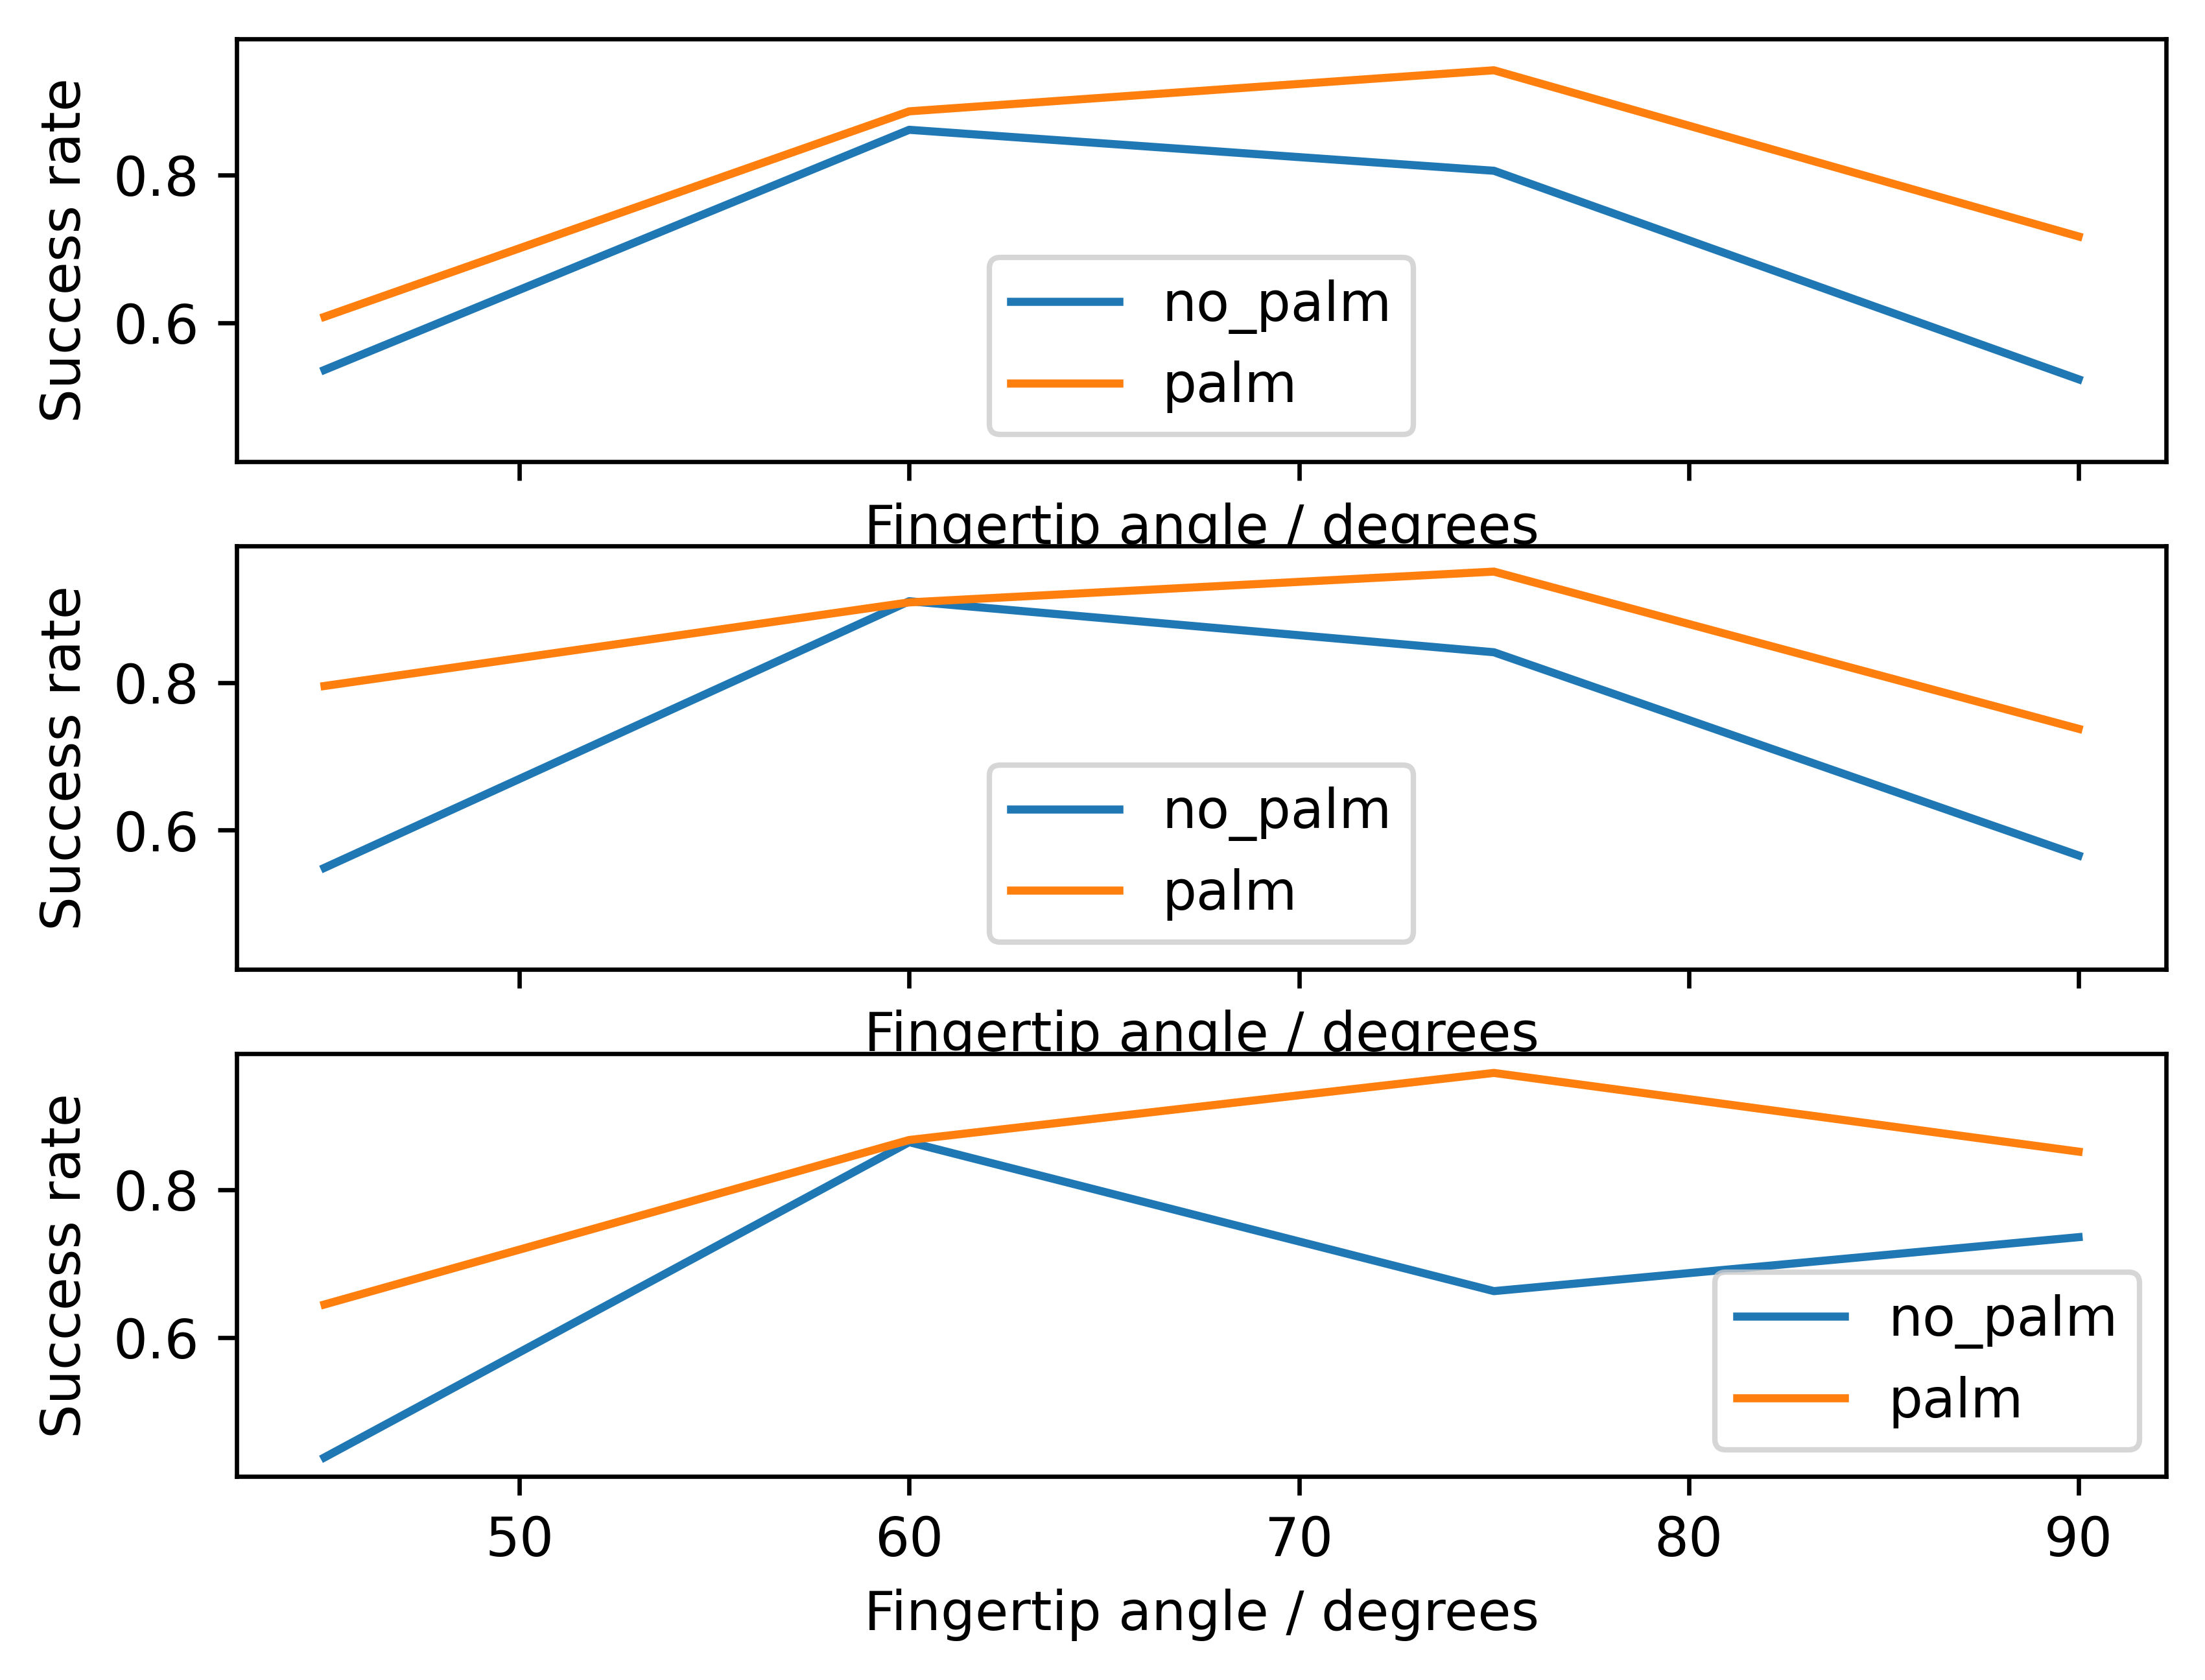

In [43]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)

for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    for i in range(len(palms)):

      # plot success rate
      x = [45, 60, 75, 90]
      y = [
        results[i][j][0].avg_SR_per_obj,
        results[i][j][1].avg_SR_per_obj,
        results[i][j][2].avg_SR_per_obj,
        results[i][j][3].avg_SR_per_obj,
      ]

      axs[j].plot(x, y, label=palms[i])
      axs[j].legend()
      axs[j].set(xlabel="Fingertip angle / degrees")
      axs[j].set(ylabel="Success rate")

# fig.set_size_inches(3.5, 7)

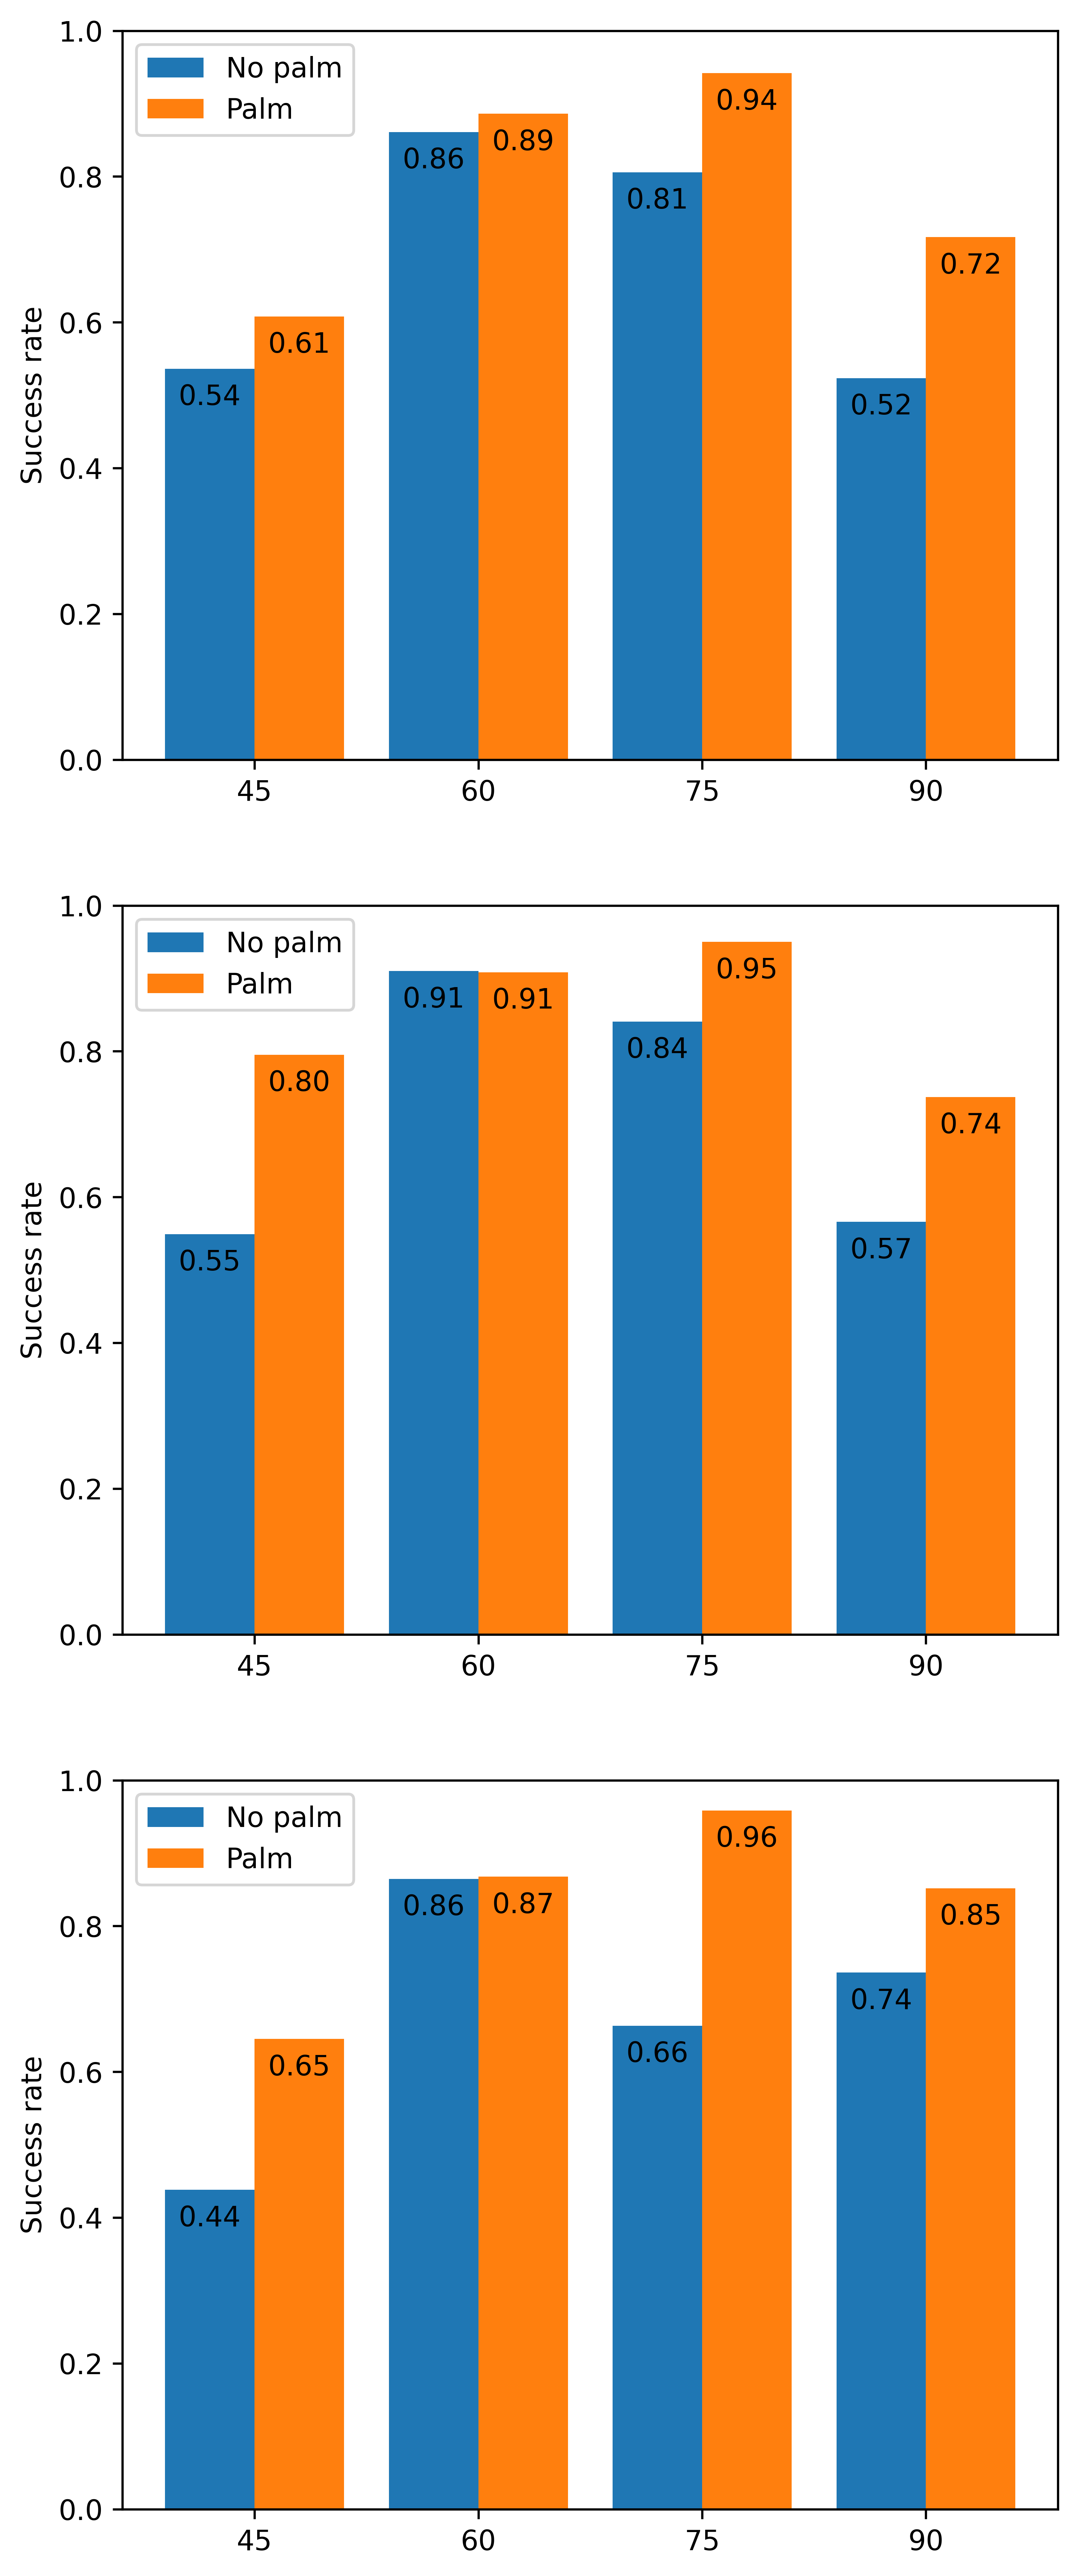

In [44]:
fig, axs = plt.subplots(3, 1, sharey=True)

angles = ["45", "60", "75", "90"]
label_locations = np.arange(len(angles))

for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):

      width = 0.4
      multiplier = 0.5 # zero for odd bars, 0.5 for even

      # bar chart data
      rates = {
        "No palm" : (
            results[0][j][0].avg_SR_per_obj,
            results[0][j][1].avg_SR_per_obj,
            results[0][j][2].avg_SR_per_obj,
            results[0][j][3].avg_SR_per_obj,
        ),
        "Palm" : (
            results[1][j][0].avg_SR_per_obj,
            results[1][j][1].avg_SR_per_obj,
            results[1][j][2].avg_SR_per_obj,
            results[1][j][3].avg_SR_per_obj,
        ),
      }

      for attribute, measurement in rates.items():
        offset = width * multiplier
        rects = axs[j].bar(label_locations + offset, measurement, width, label=attribute)
        axs[j].bar_label(rects, padding=-15, fmt="%.2f")
        multiplier += 1

      # Add some text for labels, title and custom x-axis tick labels, etc.
      axs[j].set_ylabel("Success rate")
      # axs[j].set_title("Grasp success rate across finger stiffnesses")
      axs[j].set_xticks(label_locations + width, angles)
      axs[j].legend(loc="upper left", ncols=1)
      axs[j].set_ylim(0, 1.0)

fig.set_size_inches(6, 16)

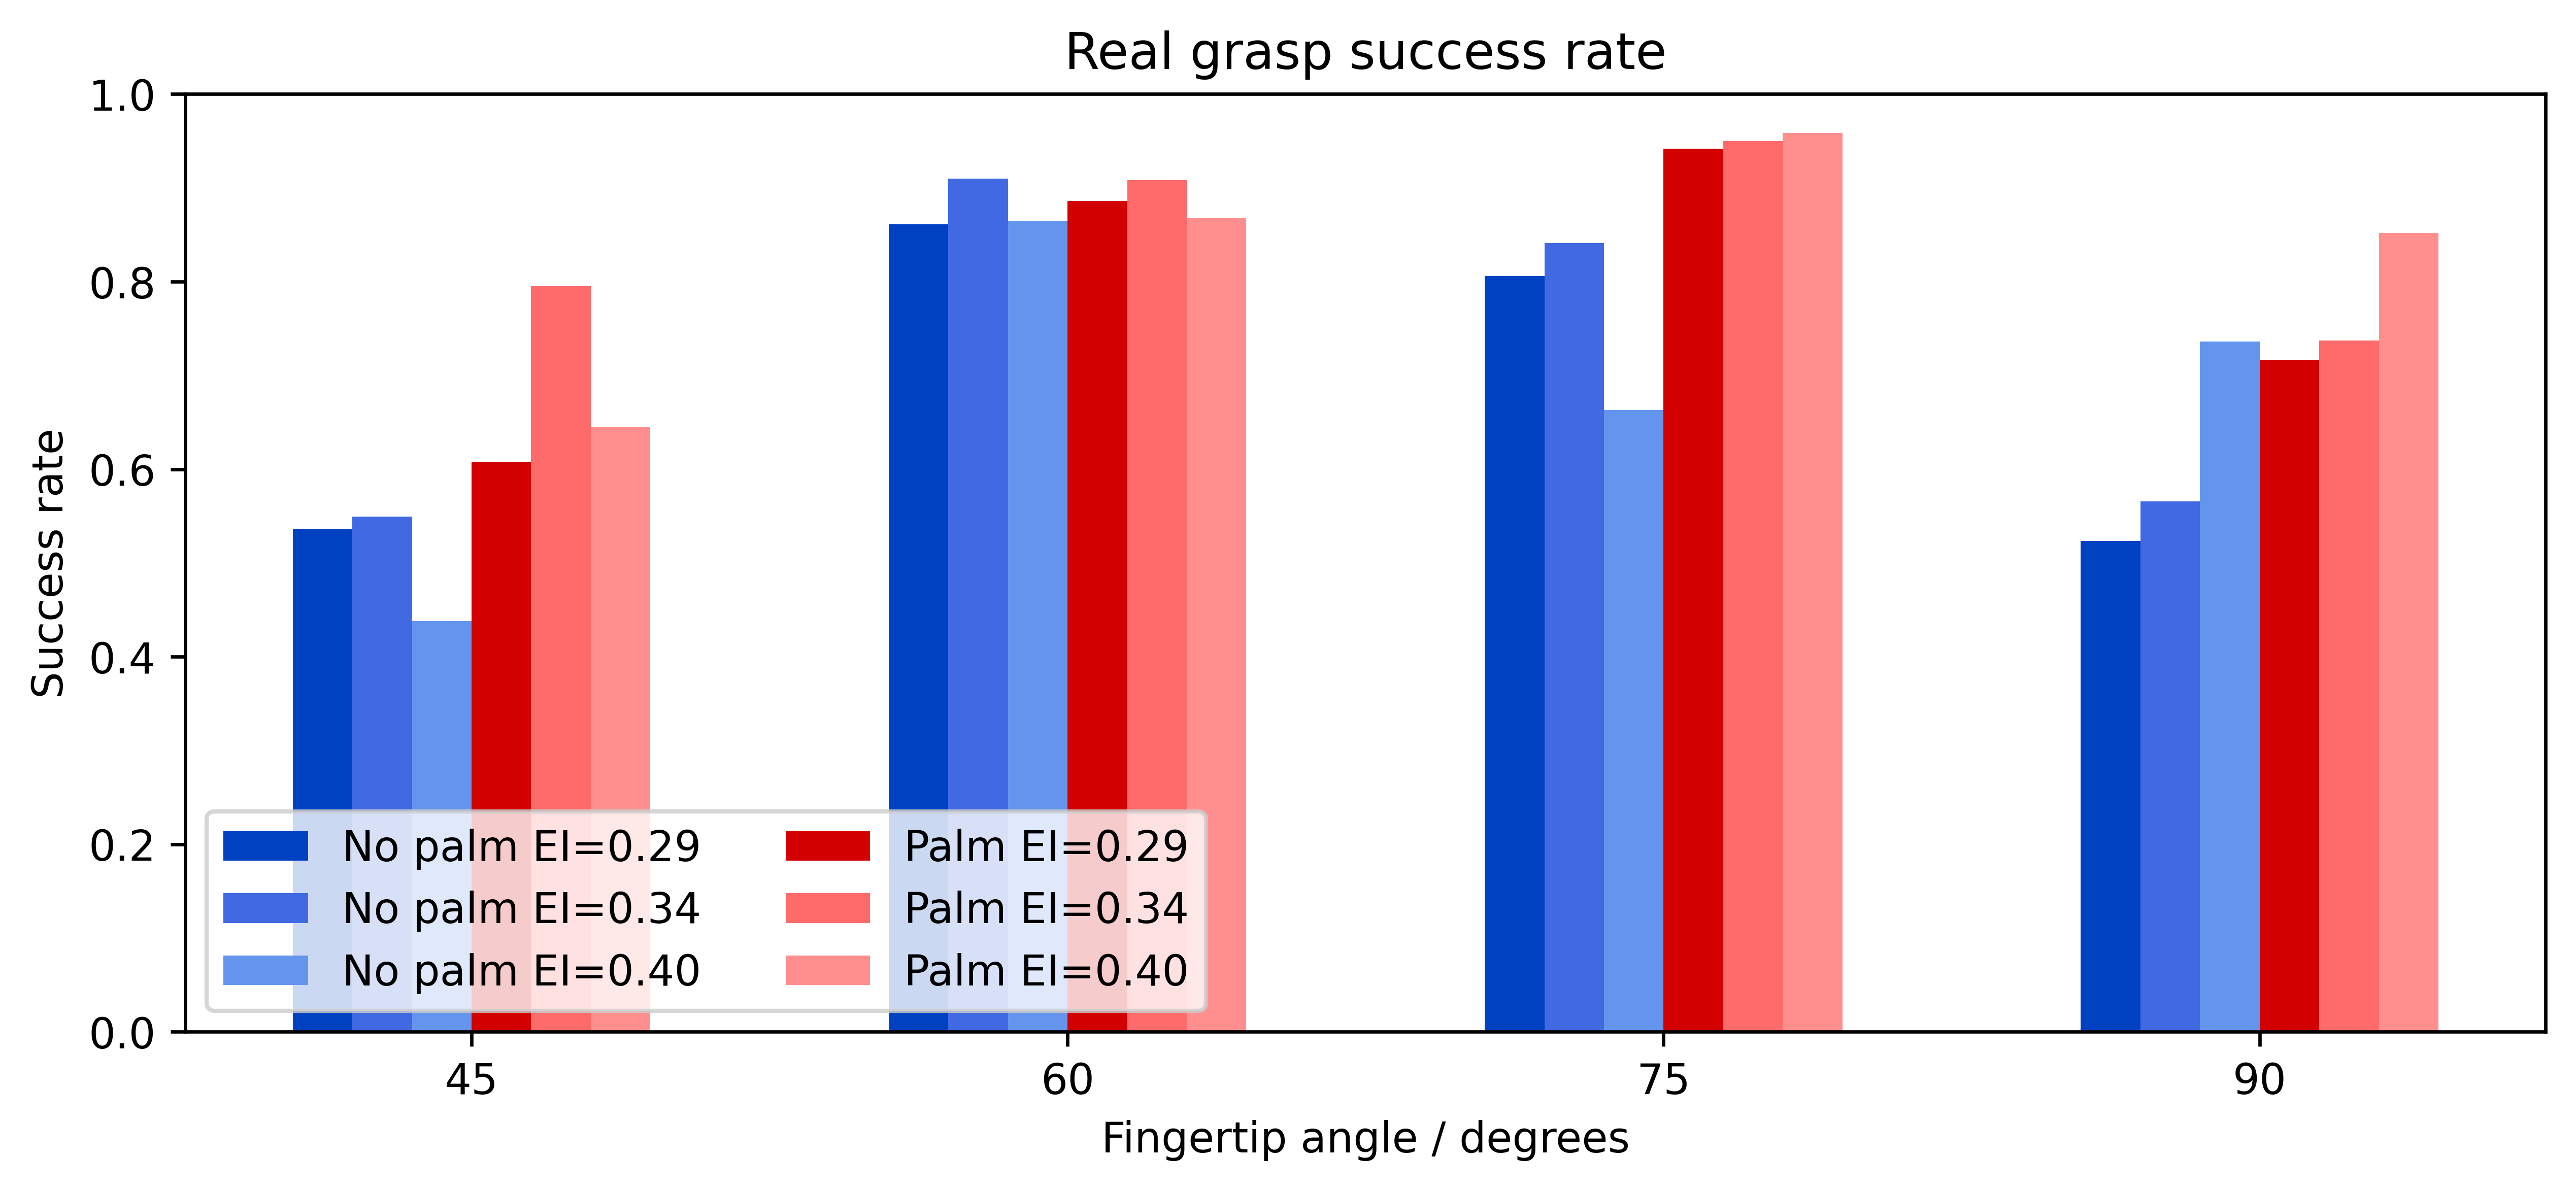

In [45]:
fig, axs = plt.subplots(1, 1, sharey=True)

angles = ["45", "60", "75", "90"]
label_locations = np.arange(len(angles))

# for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):

colours = ["#0041C2", "#4169E1", "#6495ED",
           "#D30000", "#FF6B6B", "#ff8f8f"]

width = 0.1
multiplier = -1.5 # zero for odd bars, 0.5 for even

# bar chart data
rates = {
  "No palm EI=0.29" : (
      results[0][0][0].avg_SR_per_obj,
      results[0][0][1].avg_SR_per_obj,
      results[0][0][2].avg_SR_per_obj,
      results[0][0][3].avg_SR_per_obj,
  ),
  "No palm EI=0.34" : (
      results[0][1][0].avg_SR_per_obj,
      results[0][1][1].avg_SR_per_obj,
      results[0][1][2].avg_SR_per_obj,
      results[0][1][3].avg_SR_per_obj,
  ),
  "No palm EI=0.40" : (
      results[0][2][0].avg_SR_per_obj,
      results[0][2][1].avg_SR_per_obj,
      results[0][2][2].avg_SR_per_obj,
      results[0][2][3].avg_SR_per_obj,
  ),
  "Palm EI=0.29" : (
      results[1][0][0].avg_SR_per_obj,
      results[1][0][1].avg_SR_per_obj,
      results[1][0][2].avg_SR_per_obj,
      results[1][0][3].avg_SR_per_obj,
  ),
  "Palm EI=0.34" : (
      results[1][1][0].avg_SR_per_obj,
      results[1][1][1].avg_SR_per_obj,
      results[1][1][2].avg_SR_per_obj,
      results[1][1][3].avg_SR_per_obj,
  ),
  "Palm EI=0.40" : (
      results[1][2][0].avg_SR_per_obj,
      results[1][2][1].avg_SR_per_obj,
      results[1][2][2].avg_SR_per_obj,
      results[1][2][3].avg_SR_per_obj,
  ),
}

for ijk, (attribute, measurement) in enumerate(rates.items()):
  offset = width * multiplier
  rects = axs.bar(label_locations + offset, measurement, width, label=attribute, color=colours[ijk])
  # axs.bar_label(rects, padding=-15, fmt="%.2f")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_xlabel("Fingertip angle / degrees")
axs.set_ylabel("Success rate")
axs.set_title("Real grasp success rate")
axs.set_xticks(label_locations + width, angles)
axs.legend(loc="lower left", ncols=2)
axs.set_ylim(0, 1.0)

fig.set_size_inches(10, 4)

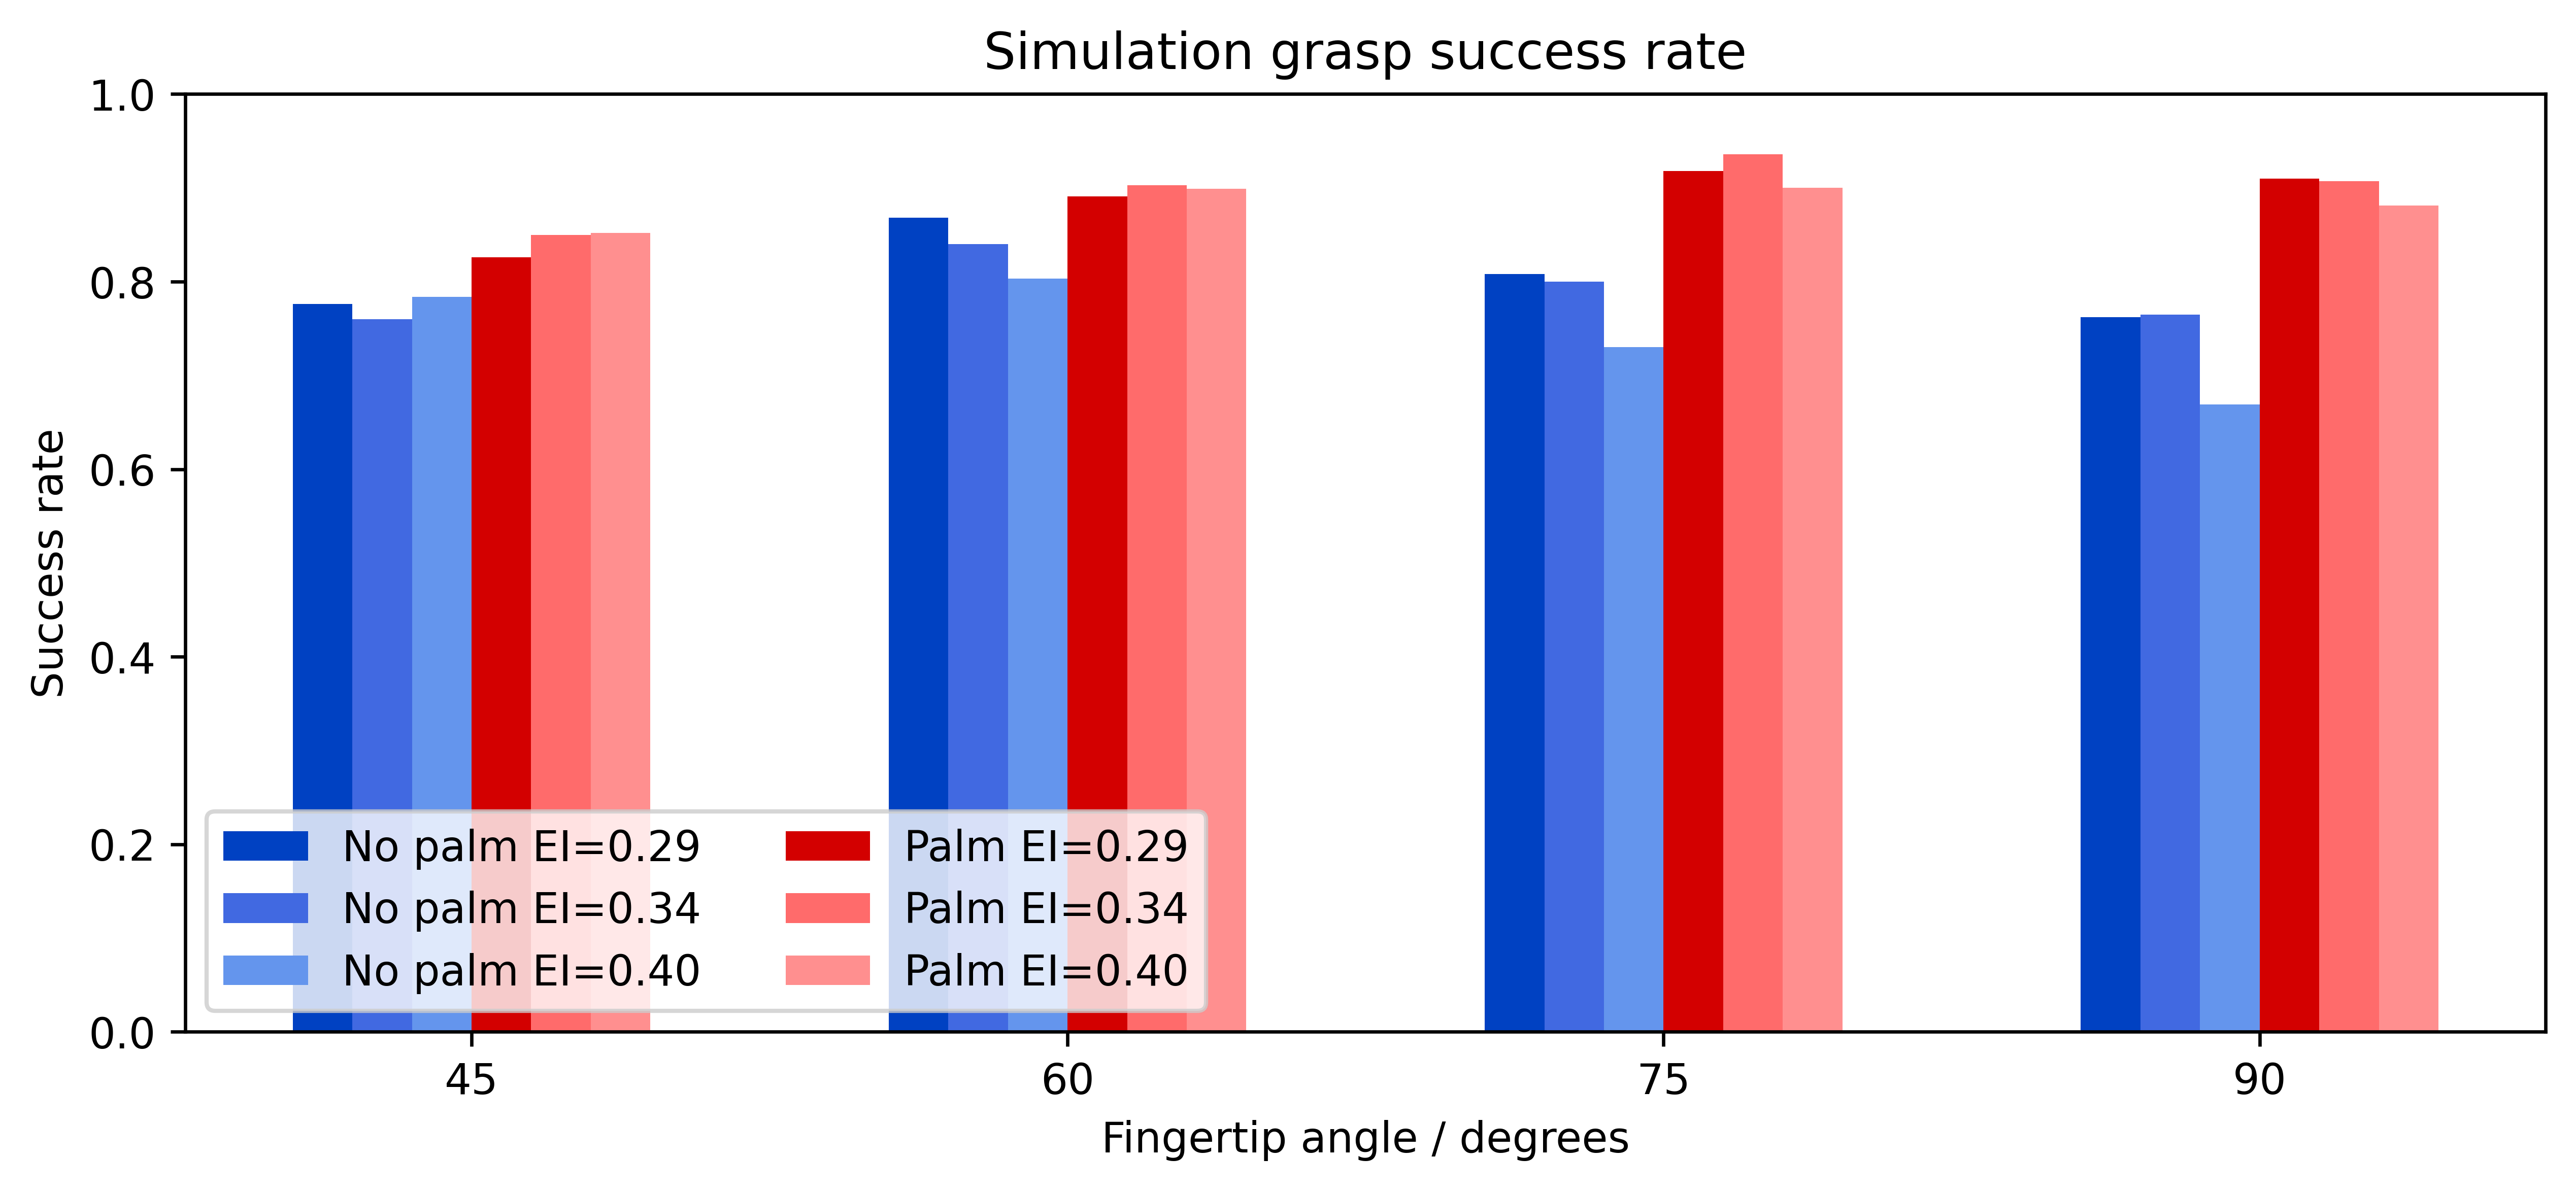

In [46]:
fig, axs = plt.subplots(1, 1, sharey=True)

angles = ["45", "60", "75", "90"]
label_locations = np.arange(len(angles))

# for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):

colours = ["#0041C2", "#4169E1", "#6495ED",
           "#D30000", "#FF6B6B", "#ff8f8f"]

width = 0.1
multiplier = -1.5 # zero for odd bars, 0.5 for even

# bar chart data
rates = {
  "No palm EI=0.29" : (
      results[0][0][0].sim_SR,
      results[0][0][1].sim_SR,
      results[0][0][2].sim_SR,
      results[0][0][3].sim_SR,
  ),
  "No palm EI=0.34" : (
      results[0][1][0].sim_SR,
      results[0][1][1].sim_SR,
      results[0][1][2].sim_SR,
      results[0][1][3].sim_SR,
  ),
  "No palm EI=0.40" : (
      results[0][2][0].sim_SR,
      results[0][2][1].sim_SR,
      results[0][2][2].sim_SR,
      results[0][2][3].sim_SR,
  ),
  "Palm EI=0.29" : (
      results[1][0][0].sim_SR,
      results[1][0][1].sim_SR,
      results[1][0][2].sim_SR,
      results[1][0][3].sim_SR,
  ),
  "Palm EI=0.34" : (
      results[1][1][0].sim_SR,
      results[1][1][1].sim_SR,
      results[1][1][2].sim_SR,
      results[1][1][3].sim_SR,
  ),
  "Palm EI=0.40" : (
      results[1][2][0].sim_SR,
      results[1][2][1].sim_SR,
      results[1][2][2].sim_SR,
      results[1][2][3].sim_SR,
  ),
}

for ijk, (attribute, measurement) in enumerate(rates.items()):
  offset = width * multiplier
  rects = axs.bar(label_locations + offset, measurement, width, label=attribute, color=colours[ijk])
  # axs.bar_label(rects, padding=-15, fmt="%.2f")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_xlabel("Fingertip angle / degrees")
axs.set_ylabel("Success rate")
axs.set_title("Simulation grasp success rate")
axs.set_xticks(label_locations + width, angles)
axs.legend(loc="lower left", ncols=2)
axs.set_ylim(0, 1.0)

fig.set_size_inches(10, 4)

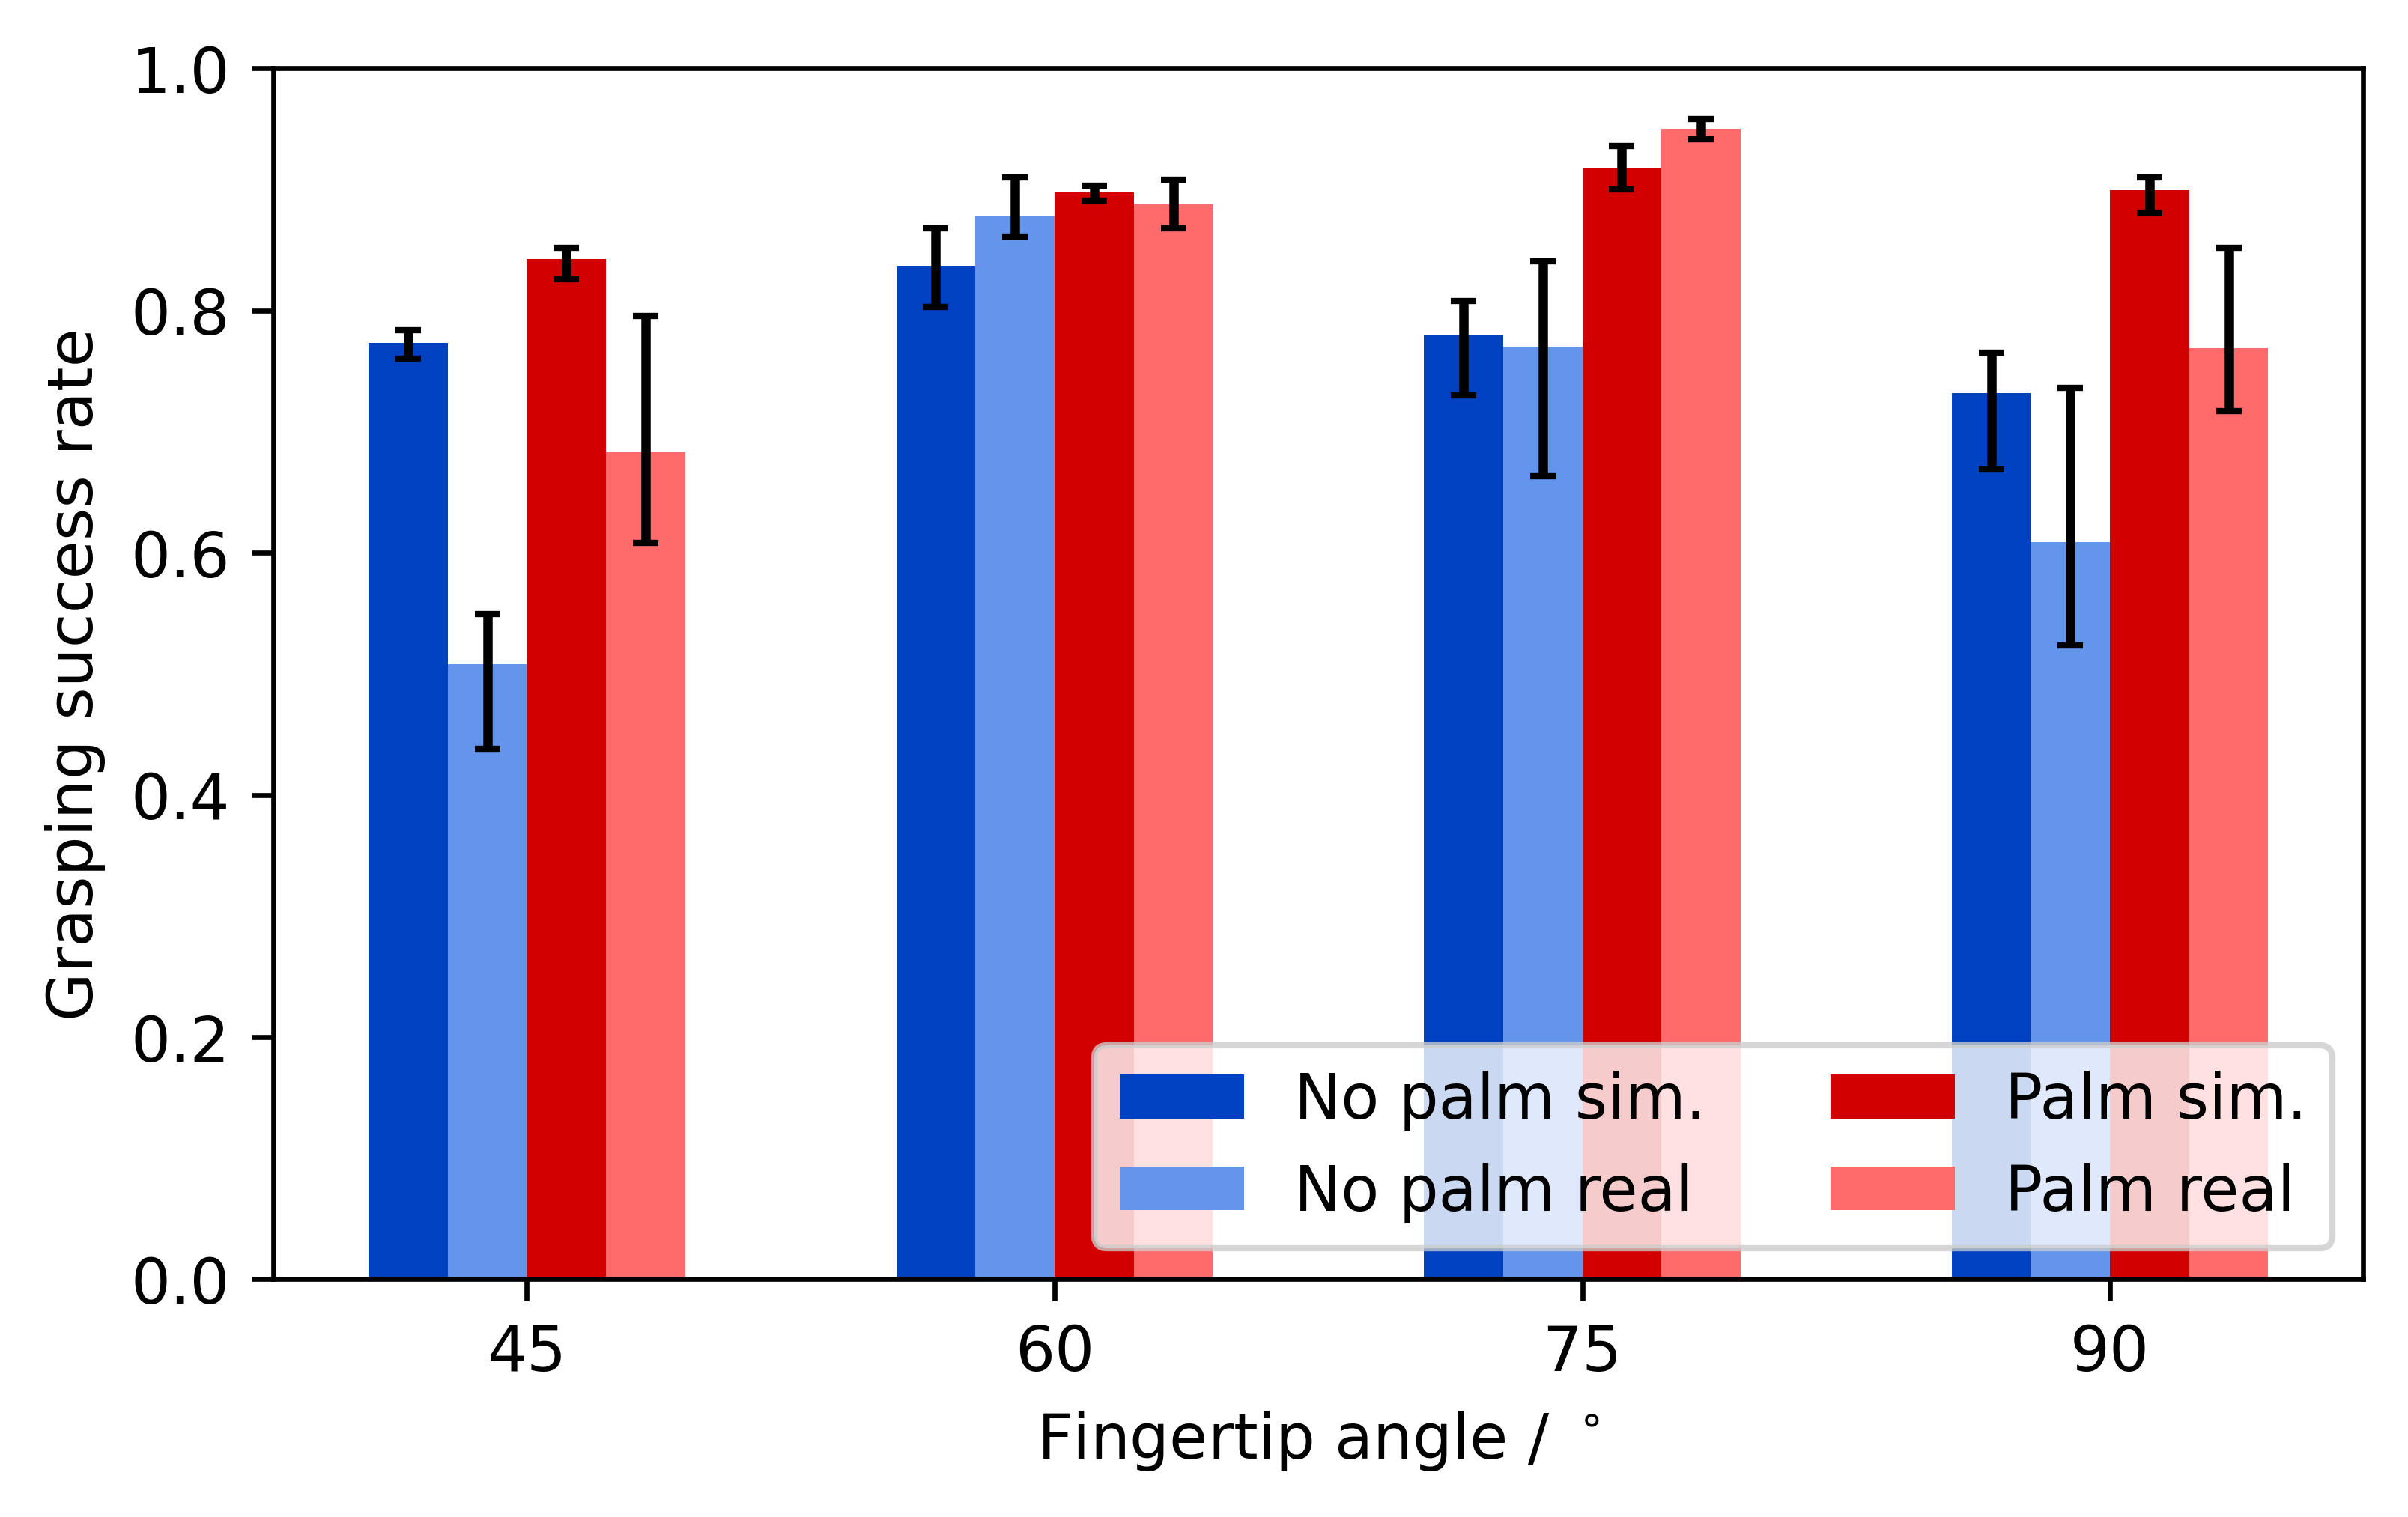

In [47]:
fig, axs = plt.subplots(1, 1, sharey=True)

angles = ["45", "60", "75", "90"]
label_locations = np.arange(len(angles))

# for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):

colours = ["#0041C2", "#6495ED",
           "#D30000", "#FF6B6B"]
patterns = None #["", "///", "", "///"]
edgecolours = None #["#0041C2", "#0041C2", "#D30000", "#D30000"]

no_palm_45 = np.array([results[0][x][0].avg_SR_per_obj for x in range(3)])
no_palm_60 = np.array([results[0][x][1].avg_SR_per_obj for x in range(3)])
no_palm_75 = np.array([results[0][x][2].avg_SR_per_obj for x in range(3)])
no_palm_90 = np.array([results[0][x][3].avg_SR_per_obj for x in range(3)])
palm_45 = np.array([results[1][x][0].avg_SR_per_obj for x in range(3)])
palm_60 = np.array([results[1][x][1].avg_SR_per_obj for x in range(3)])
palm_75 = np.array([results[1][x][2].avg_SR_per_obj for x in range(3)])
palm_90 = np.array([results[1][x][3].avg_SR_per_obj for x in range(3)])

sim_no_palm_45 = np.array([results[0][x][0].sim_SR for x in range(3)])
sim_no_palm_60 = np.array([results[0][x][1].sim_SR for x in range(3)])
sim_no_palm_75 = np.array([results[0][x][2].sim_SR for x in range(3)])
sim_no_palm_90 = np.array([results[0][x][3].sim_SR for x in range(3)])
sim_palm_45 = np.array([results[1][x][0].sim_SR for x in range(3)])
sim_palm_60 = np.array([results[1][x][1].sim_SR for x in range(3)])
sim_palm_75 = np.array([results[1][x][2].sim_SR for x in range(3)])
sim_palm_90 = np.array([results[1][x][3].sim_SR for x in range(3)])

width = 0.15
multiplier = -0.5

# bar chart data
rates = {
  "No palm sim." : (
      sim_no_palm_45,
      sim_no_palm_60,
      sim_no_palm_75,
      sim_no_palm_90,
  ),
  "No palm real" : (
      no_palm_45,
      no_palm_60,
      no_palm_75,
      no_palm_90,
  ),
  "Palm sim." : (
      sim_palm_45,
      sim_palm_60,
      sim_palm_75,
      sim_palm_90,
  ),
  "Palm real" : (
      palm_45,
      palm_60,
      palm_75,
      palm_90,
  ),
}

for ijk, (attribute, measurement) in enumerate(rates.items()):
  avg = np.average(measurement, axis=1)
  yerr=(avg - np.min(measurement, axis=1), 
        np.max(measurement, axis=1) - avg)
  offset = width * multiplier
  rects = axs.bar(label_locations + offset, avg, width, label=attribute, yerr=yerr,
                  capsize=2,  color=colours[ijk])
                  # , hatch=patterns[ijk], edgecolor=edgecolours[ijk])
  # axs.bar_label(rects, padding=-15, fmt="%.2f")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_xlabel("Fingertip angle / $^\circ$")
axs.set_ylabel("Grasping success rate")
# axs.set_title("Grasp success rate across finger stiffnesses")
axs.set_xticks(label_locations + width, angles)
axs.legend(loc="lower right", ncols=2)
axs.set_ylim(0, 1.0)

fig.set_size_inches(6, 3.5)

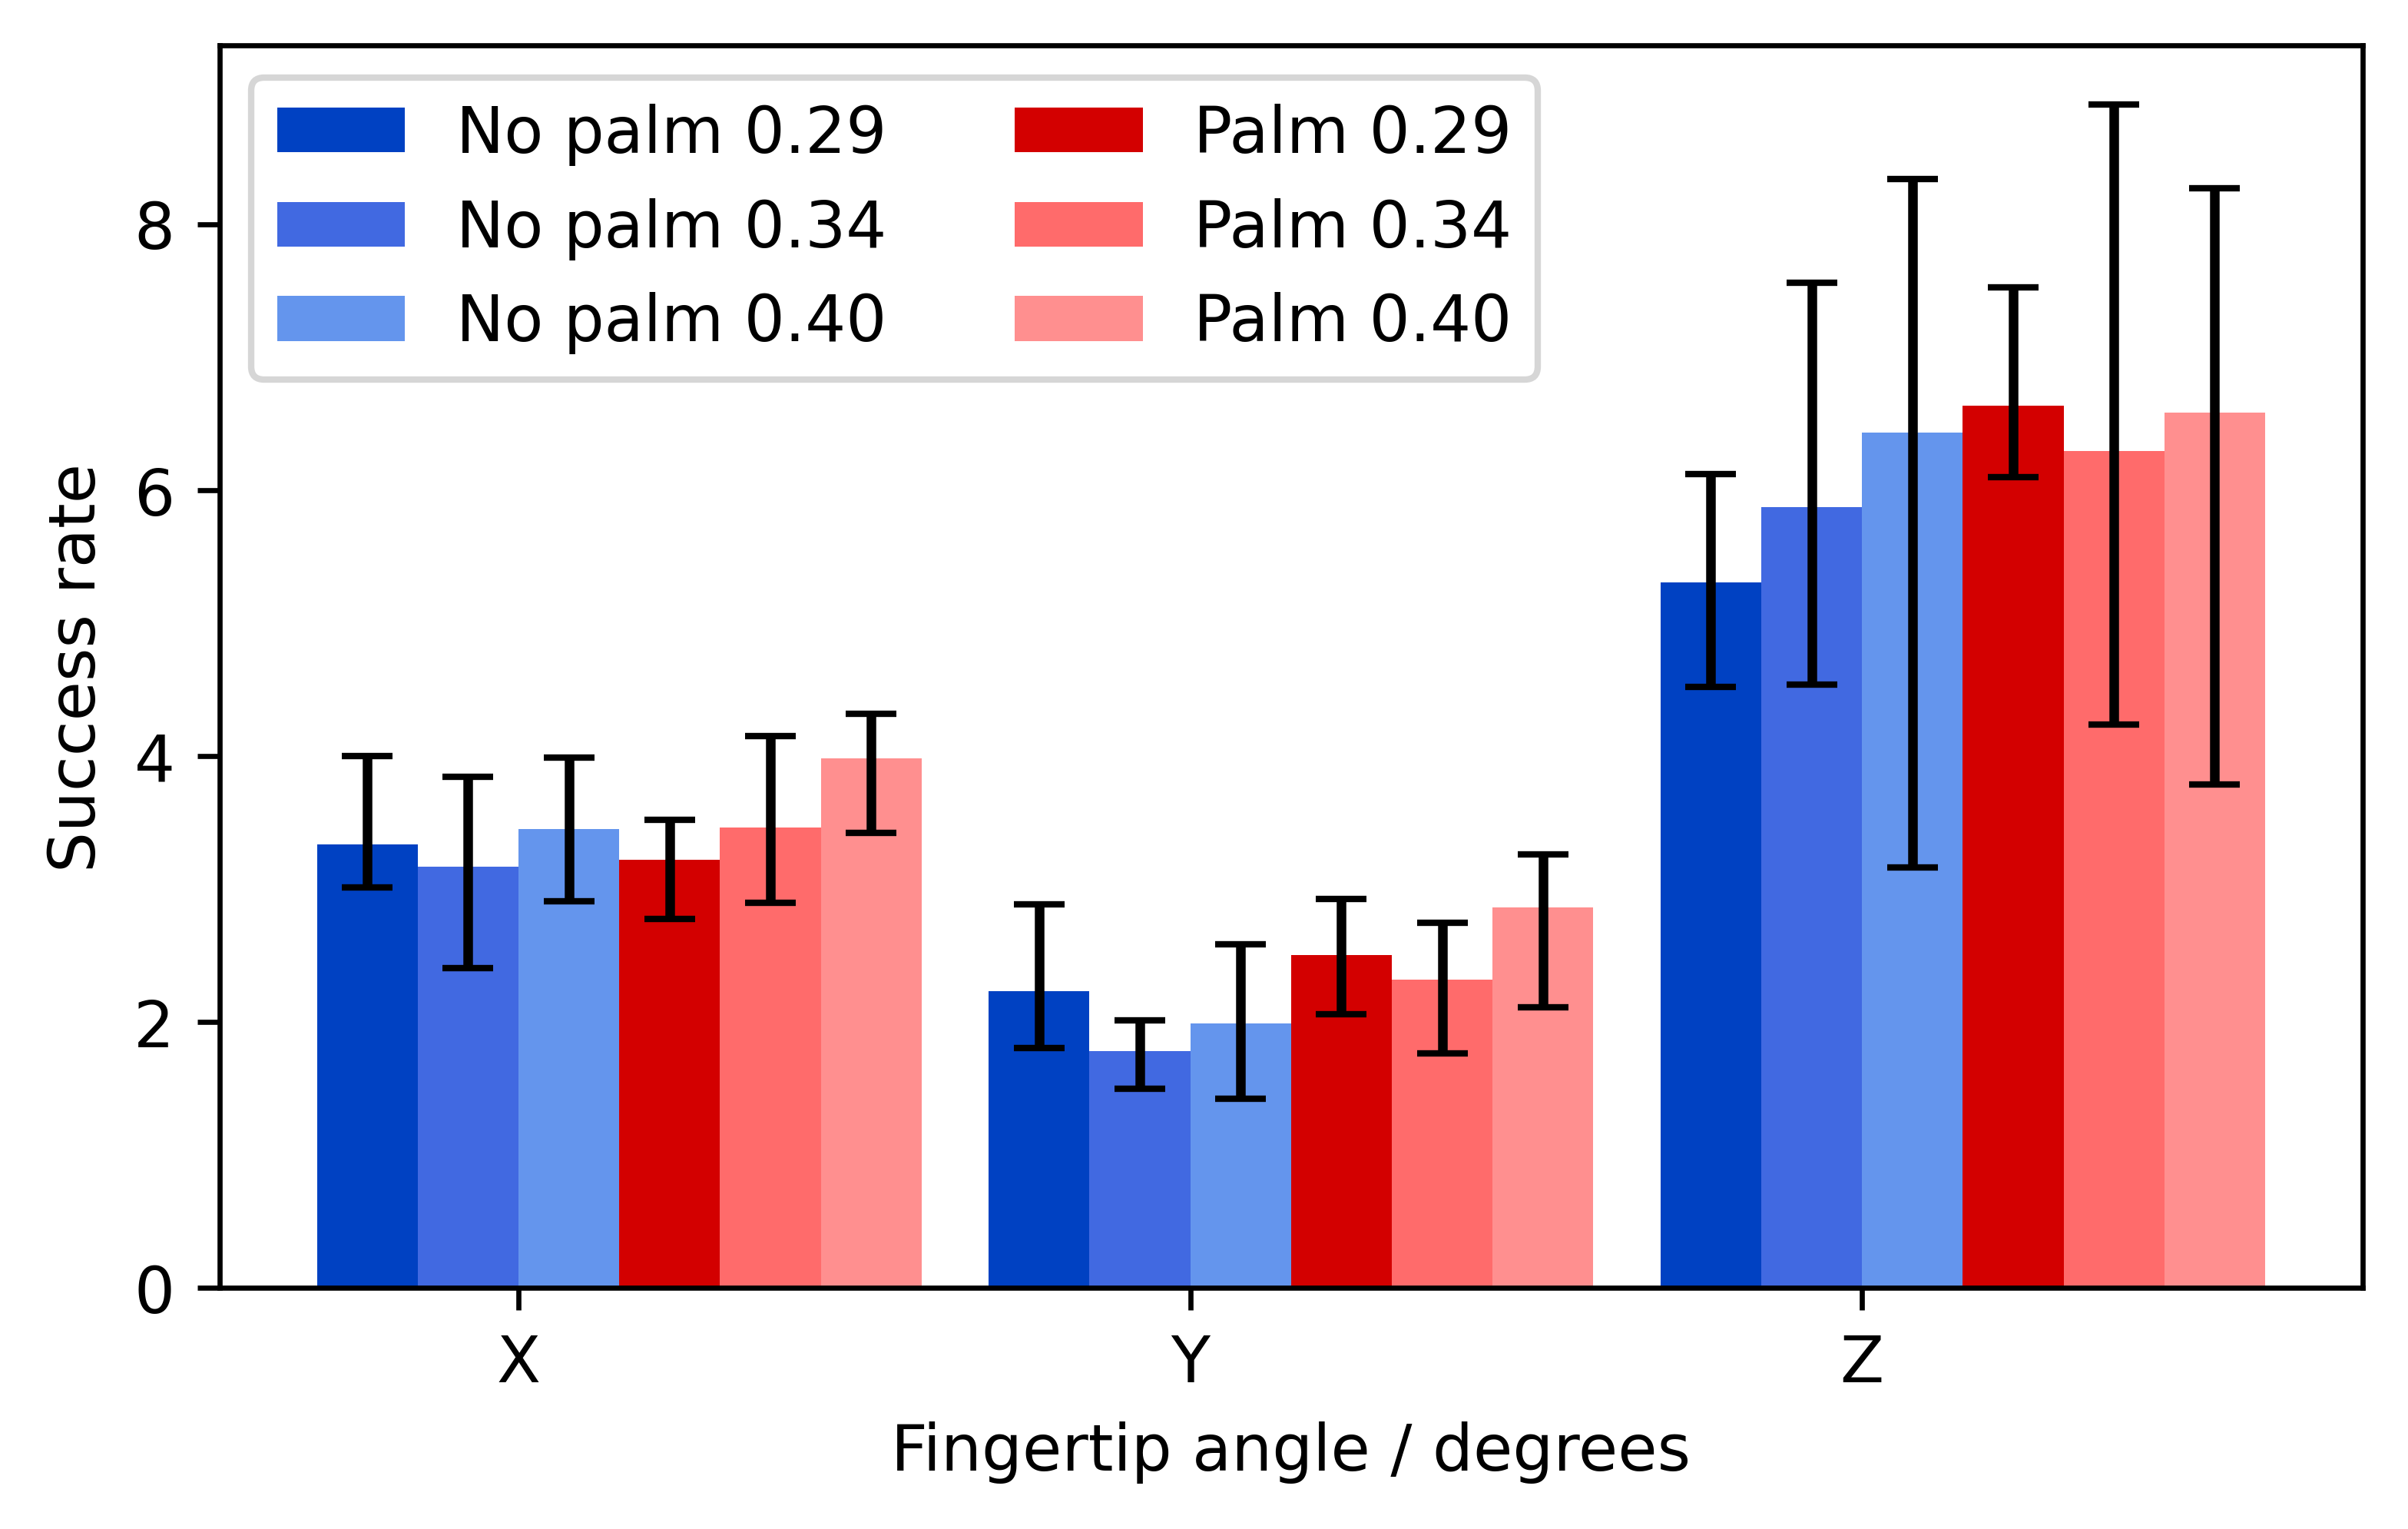

In [48]:
fig, axs = plt.subplots(1, 1, sharey=True)

x_axis = ["X", "Y", "Z"]
label_locations = np.arange(len(x_axis))

# for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):

# colours = ["#0041C2", "#6495ED",
#            "#D30000", "#FF6B6B"]
colours = ["#0041C2", "#4169E1", "#6495ED",
           "#D30000", "#FF6B6B", "#ff8f8f"]
patterns = ["", "///", "", "///"]
edgecolours = ["#0041C2", "#0041C2",
               "#D30000", "#D30000"]

no_palm_29_x = np.array([results[0][0][x].avg_X_frc_saturated for x in range(4)])
no_palm_34_x = np.array([results[0][1][x].avg_X_frc_saturated for x in range(4)])
no_palm_40_x = np.array([results[0][2][x].avg_X_frc_saturated for x in range(4)])
no_palm_29_y = np.array([results[0][0][x].avg_Y_frc_saturated for x in range(4)])
no_palm_34_y = np.array([results[0][1][x].avg_Y_frc_saturated for x in range(4)])
no_palm_40_y = np.array([results[0][2][x].avg_Y_frc_saturated for x in range(4)])
no_palm_29_z = np.array([results[0][0][x].avg_palm_frc_saturated for x in range(4)])
no_palm_34_z = np.array([results[0][1][x].avg_palm_frc_saturated for x in range(4)])
no_palm_40_z = np.array([results[0][2][x].avg_palm_frc_saturated for x in range(4)])

palm_29_x = np.array([results[1][0][x].avg_X_frc_saturated for x in range(4)])
palm_34_x = np.array([results[1][1][x].avg_X_frc_saturated for x in range(4)])
palm_40_x = np.array([results[1][2][x].avg_X_frc_saturated for x in range(4)])
palm_29_y = np.array([results[1][0][x].avg_Y_frc_saturated for x in range(4)])
palm_34_y = np.array([results[1][1][x].avg_Y_frc_saturated for x in range(4)])
palm_40_y = np.array([results[1][2][x].avg_Y_frc_saturated for x in range(4)])
palm_29_z = np.array([results[1][0][x].avg_palm_frc_saturated for x in range(4)])
palm_34_z = np.array([results[1][1][x].avg_palm_frc_saturated for x in range(4)])
palm_40_z = np.array([results[1][2][x].avg_palm_frc_saturated for x in range(4)])

width = 0.15
multiplier = -0.5

# bar chart data
# rates = {
#   "No palm X" : (
#       no_palm_29_x,
#       no_palm_34_x,
#       no_palm_40_x,
#   ),
#   "No palm Y" : (
#       no_palm_29_y,
#       no_palm_34_y,
#       no_palm_40_y,
#   ),
#   "No palm Z" : (
#       no_palm_29_z,
#       no_palm_34_z,
#       no_palm_40_z,
#   ),
#   "Palm X" : (
#       palm_29_x,
#       palm_34_x,
#       palm_40_x,
#   ),
#   "Palm Y" : (
#       palm_29_y,
#       palm_34_y,
#       palm_40_y,
#   ),
#   "Palm Z" : (
#       palm_29_z,
#       palm_34_z,
#       palm_40_z,
#   ),
# }

rates = {
  "No palm 0.29" : (
      no_palm_29_x,
      no_palm_29_y,
      no_palm_29_z,
  ),
  "No palm 0.34" : (
      no_palm_34_x,
      no_palm_34_y,
      no_palm_34_z,
  ),
  "No palm 0.40" : (
      no_palm_40_x,
      no_palm_40_y,
      no_palm_40_z,
  ),
  "Palm 0.29" : (
      palm_29_x,
      palm_29_y,
      palm_29_z,
  ),
  "Palm 0.34" : (
      palm_34_x,
      palm_34_y,
      palm_34_z,
  ),
  "Palm 0.40" : (
      palm_40_x,
      palm_40_y,
      palm_40_z,
  ),
}

for ijk, (attribute, measurement) in enumerate(rates.items()):

  avg = np.average(measurement, axis=1)
  yerr=(avg - np.min(measurement, axis=1), 
        np.max(measurement, axis=1) - avg)
  offset = width * multiplier
  rects = axs.bar(label_locations + offset, avg, width, label=attribute, yerr=yerr,
                  capsize=4,  color=colours[ijk])
                  # , hatch=patterns[ijk], edgecolor=edgecolours[ijk])
  # axs.bar_label(rects, padding=-15, fmt="%.2f")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_xlabel("Fingertip angle / degrees")
axs.set_ylabel("Success rate")
# axs.set_title("Grasp success rate across finger stiffnesses")
axs.set_xticks(label_locations + width, x_axis)
axs.legend(loc="upper left", ncols=2)
# axs.set_ylim(0, 1.0)

fig.set_size_inches(6, 3.5)

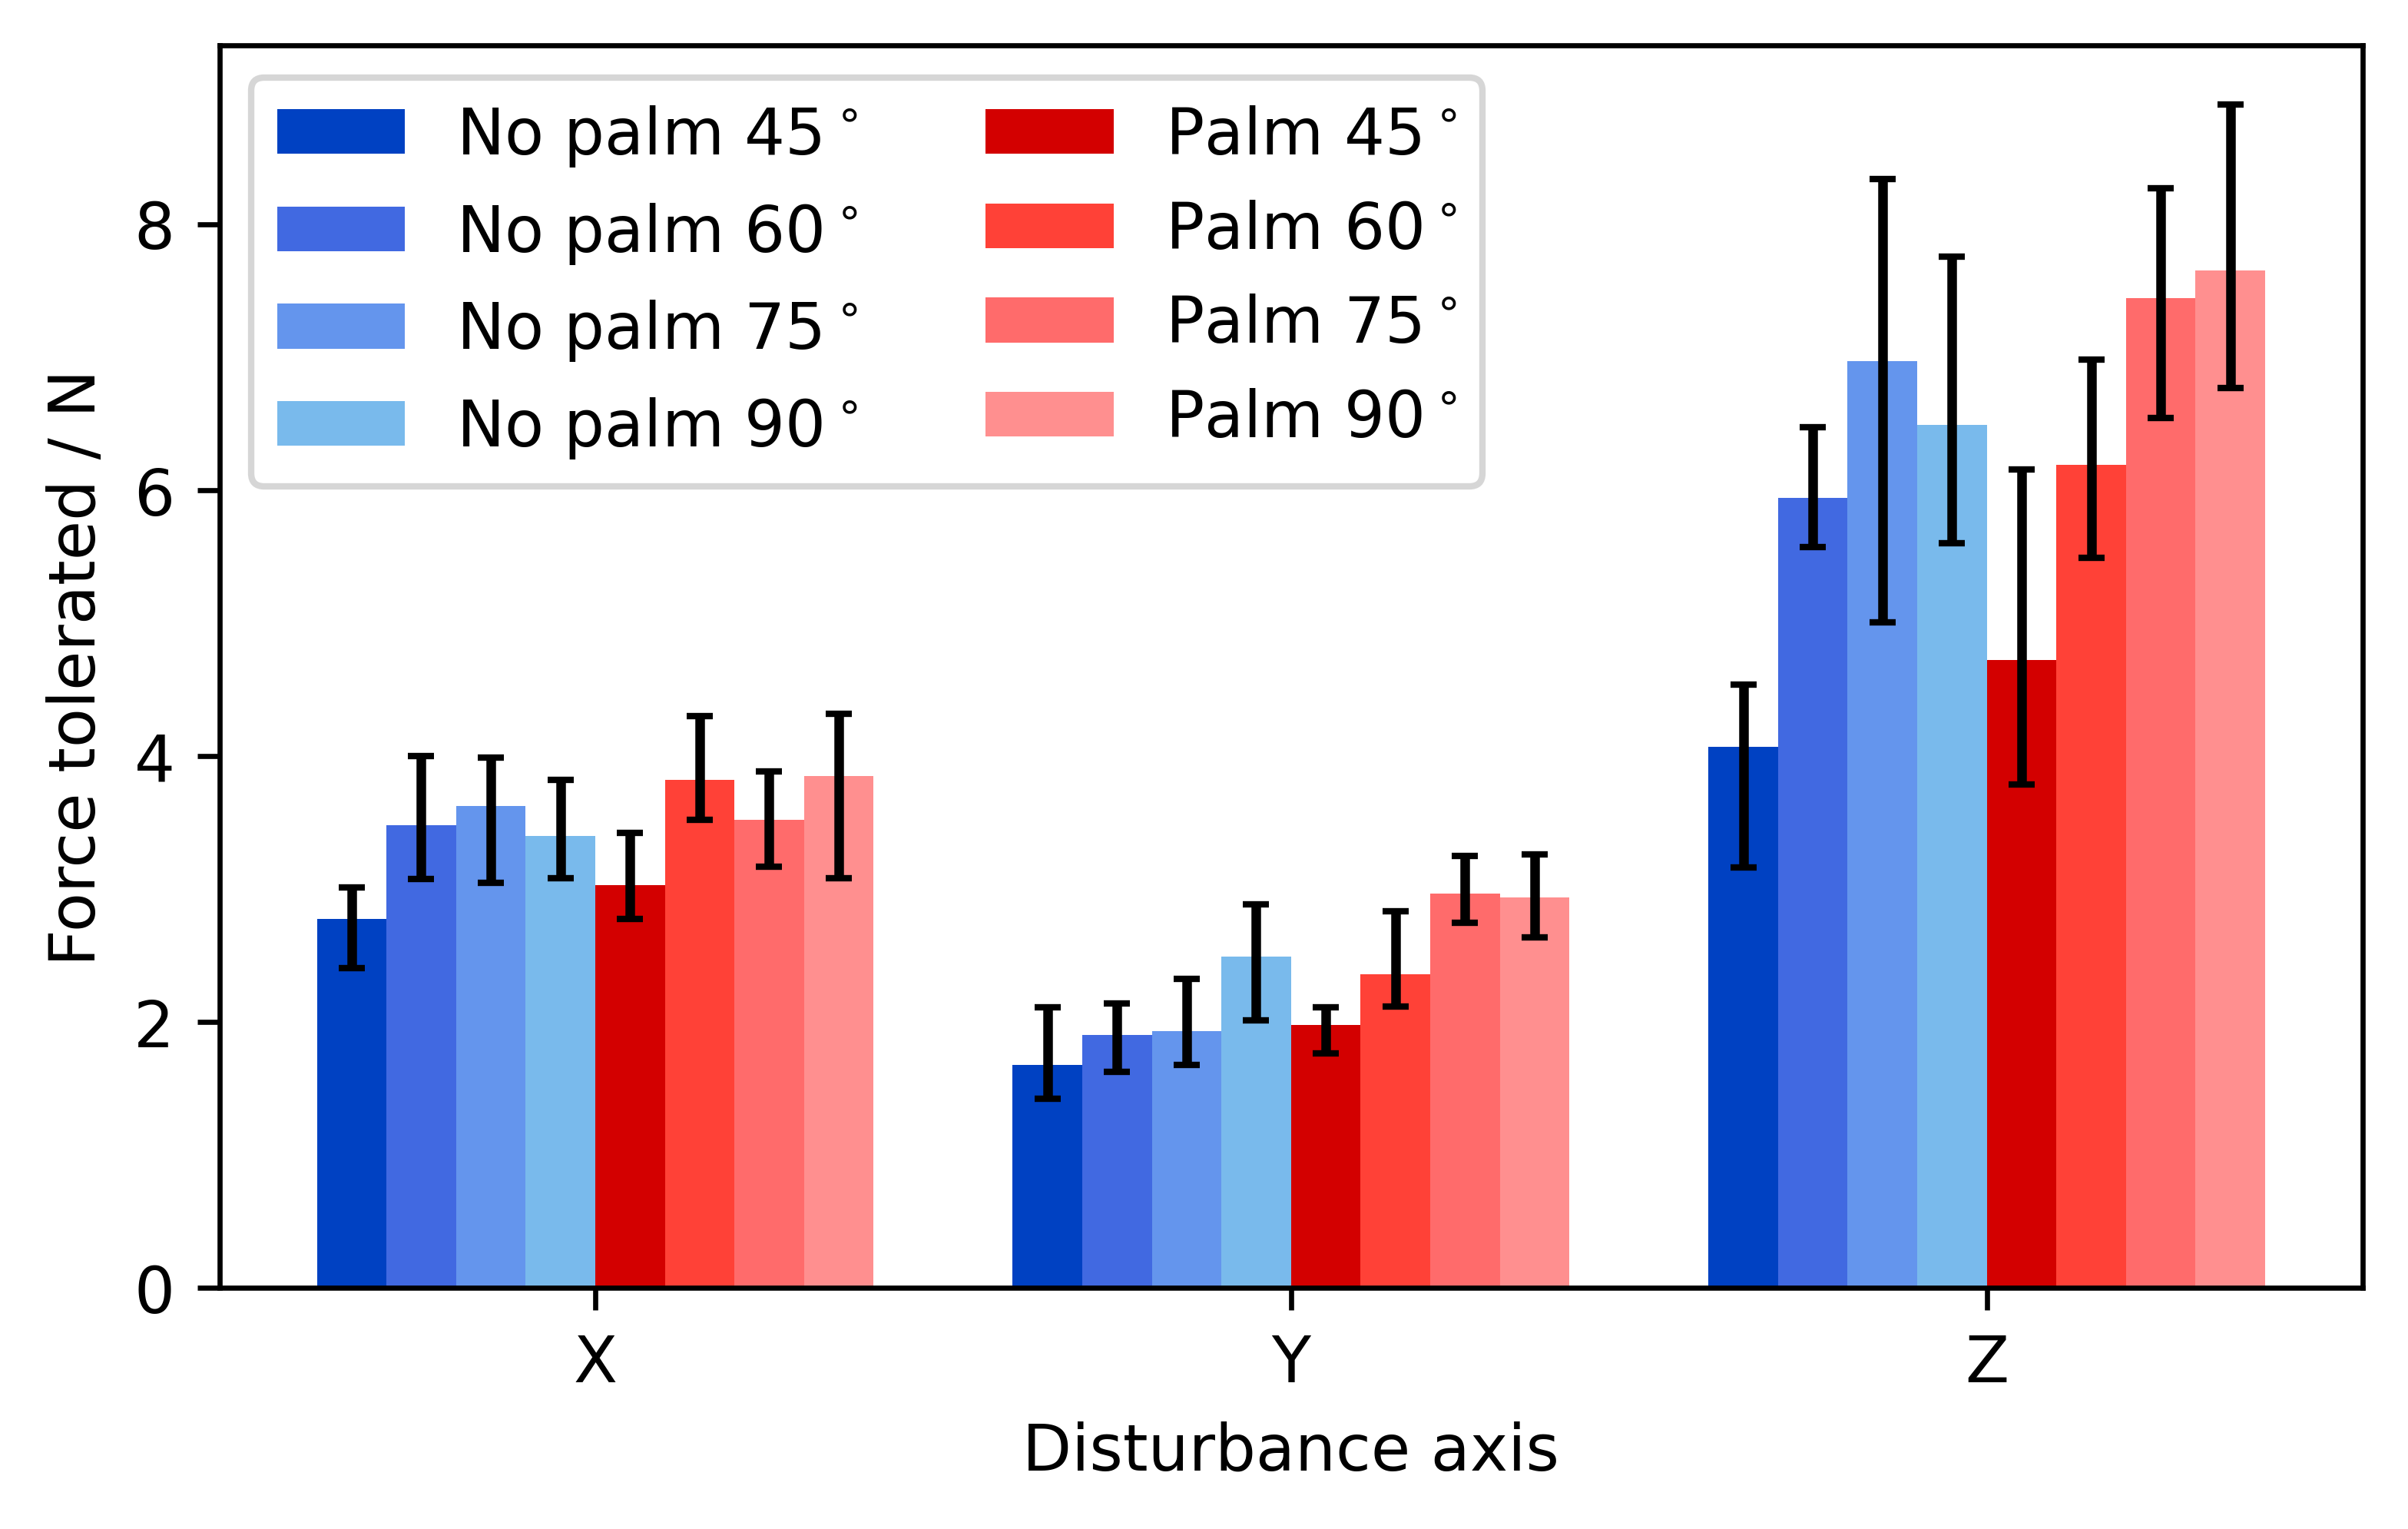

In [49]:
fig, axs = plt.subplots(1, 1, sharey=True)

x_axis = ["X", "Y", "Z"]
label_locations = np.arange(len(x_axis))

# for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):

colours = ["#0041C2", "#4169E1", "#6495ED", "#79baec",
           "#D30000", "#ff4137", "#FF6B6B", "#ff8f8f"]
patterns = ["", "///", "", "///"]
edgecolours = ["#0041C2", "#0041C2",
               "#D30000", "#D30000"]

no_palm_45_x = np.array([results[0][x][0].avg_X_frc_saturated for x in range(3)])
no_palm_60_x = np.array([results[0][x][1].avg_X_frc_saturated for x in range(3)])
no_palm_75_x = np.array([results[0][x][2].avg_X_frc_saturated for x in range(3)])
no_palm_90_x = np.array([results[0][x][3].avg_X_frc_saturated for x in range(3)])
no_palm_45_y = np.array([results[0][x][0].avg_Y_frc_saturated for x in range(3)])
no_palm_60_y = np.array([results[0][x][1].avg_Y_frc_saturated for x in range(3)])
no_palm_75_y = np.array([results[0][x][2].avg_Y_frc_saturated for x in range(3)])
no_palm_90_y = np.array([results[0][x][3].avg_Y_frc_saturated for x in range(3)])
no_palm_45_z = np.array([results[0][x][0].avg_palm_frc_saturated for x in range(3)])
no_palm_60_z = np.array([results[0][x][1].avg_palm_frc_saturated for x in range(3)])
no_palm_75_z = np.array([results[0][x][2].avg_palm_frc_saturated for x in range(3)])
no_palm_90_z = np.array([results[0][x][3].avg_palm_frc_saturated for x in range(3)])

palm_45_x = np.array([results[1][x][0].avg_X_frc_saturated for x in range(3)])
palm_60_x = np.array([results[1][x][1].avg_X_frc_saturated for x in range(3)])
palm_75_x = np.array([results[1][x][2].avg_X_frc_saturated for x in range(3)])
palm_90_x = np.array([results[1][x][3].avg_X_frc_saturated for x in range(3)])
palm_45_y = np.array([results[1][x][0].avg_Y_frc_saturated for x in range(3)])
palm_60_y = np.array([results[1][x][1].avg_Y_frc_saturated for x in range(3)])
palm_75_y = np.array([results[1][x][2].avg_Y_frc_saturated for x in range(3)])
palm_90_y = np.array([results[1][x][3].avg_Y_frc_saturated for x in range(3)])
palm_45_z = np.array([results[1][x][0].avg_palm_frc_saturated for x in range(3)])
palm_60_z = np.array([results[1][x][1].avg_palm_frc_saturated for x in range(3)])
palm_75_z = np.array([results[1][x][2].avg_palm_frc_saturated for x in range(3)])
palm_90_z = np.array([results[1][x][3].avg_palm_frc_saturated for x in range(3)])


width = 0.1
multiplier = -2.5

rates = {
  "No palm 45$^\circ$" : (
      no_palm_45_x,
      no_palm_45_y,
      no_palm_45_z,
  ),
  "No palm 60$^\circ$" : (
      no_palm_60_x,
      no_palm_60_y,
      no_palm_60_z,
  ),
  "No palm 75$^\circ$" : (
      no_palm_75_x,
      no_palm_75_y,
      no_palm_75_z,
  ),
  "No palm 90$^\circ$" : (
      no_palm_90_x,
      no_palm_90_y,
      no_palm_90_z,
  ),
  "Palm 45$^\circ$" : (
      palm_45_x,
      palm_45_y,
      palm_45_z,
  ),
  "Palm 60$^\circ$" : (
      palm_60_x,
      palm_60_y,
      palm_60_z,
  ),
  "Palm 75$^\circ$" : (
      palm_75_x,
      palm_75_y,
      palm_75_z,
  ),
  "Palm 90$^\circ$" : (
      palm_90_x,
      palm_90_y,
      palm_90_z,
  ),
}

for ijk, (attribute, measurement) in enumerate(rates.items()):

  avg = np.average(measurement, axis=1)
  yerr=(avg - np.min(measurement, axis=1), 
        np.max(measurement, axis=1) - avg)
  offset = width * multiplier
  rects = axs.bar(label_locations + offset, avg, width, label=attribute, yerr=yerr,
                  capsize=2,  color=colours[ijk])
                  # , hatch=patterns[ijk], edgecolor=edgecolours[ijk])
  # axs.bar_label(rects, padding=-15, fmt="%.2f")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_xlabel("Disturbance axis")
axs.set_ylabel("Force tolerated / N")
# axs.set_title("Grasp success rate across finger stiffnesses")
axs.set_xticks(label_locations + width, x_axis)
axs.legend(loc="upper left", ncols=2)
# axs.set_ylim(0, 1.0)

fig.set_size_inches(6, 3.5)

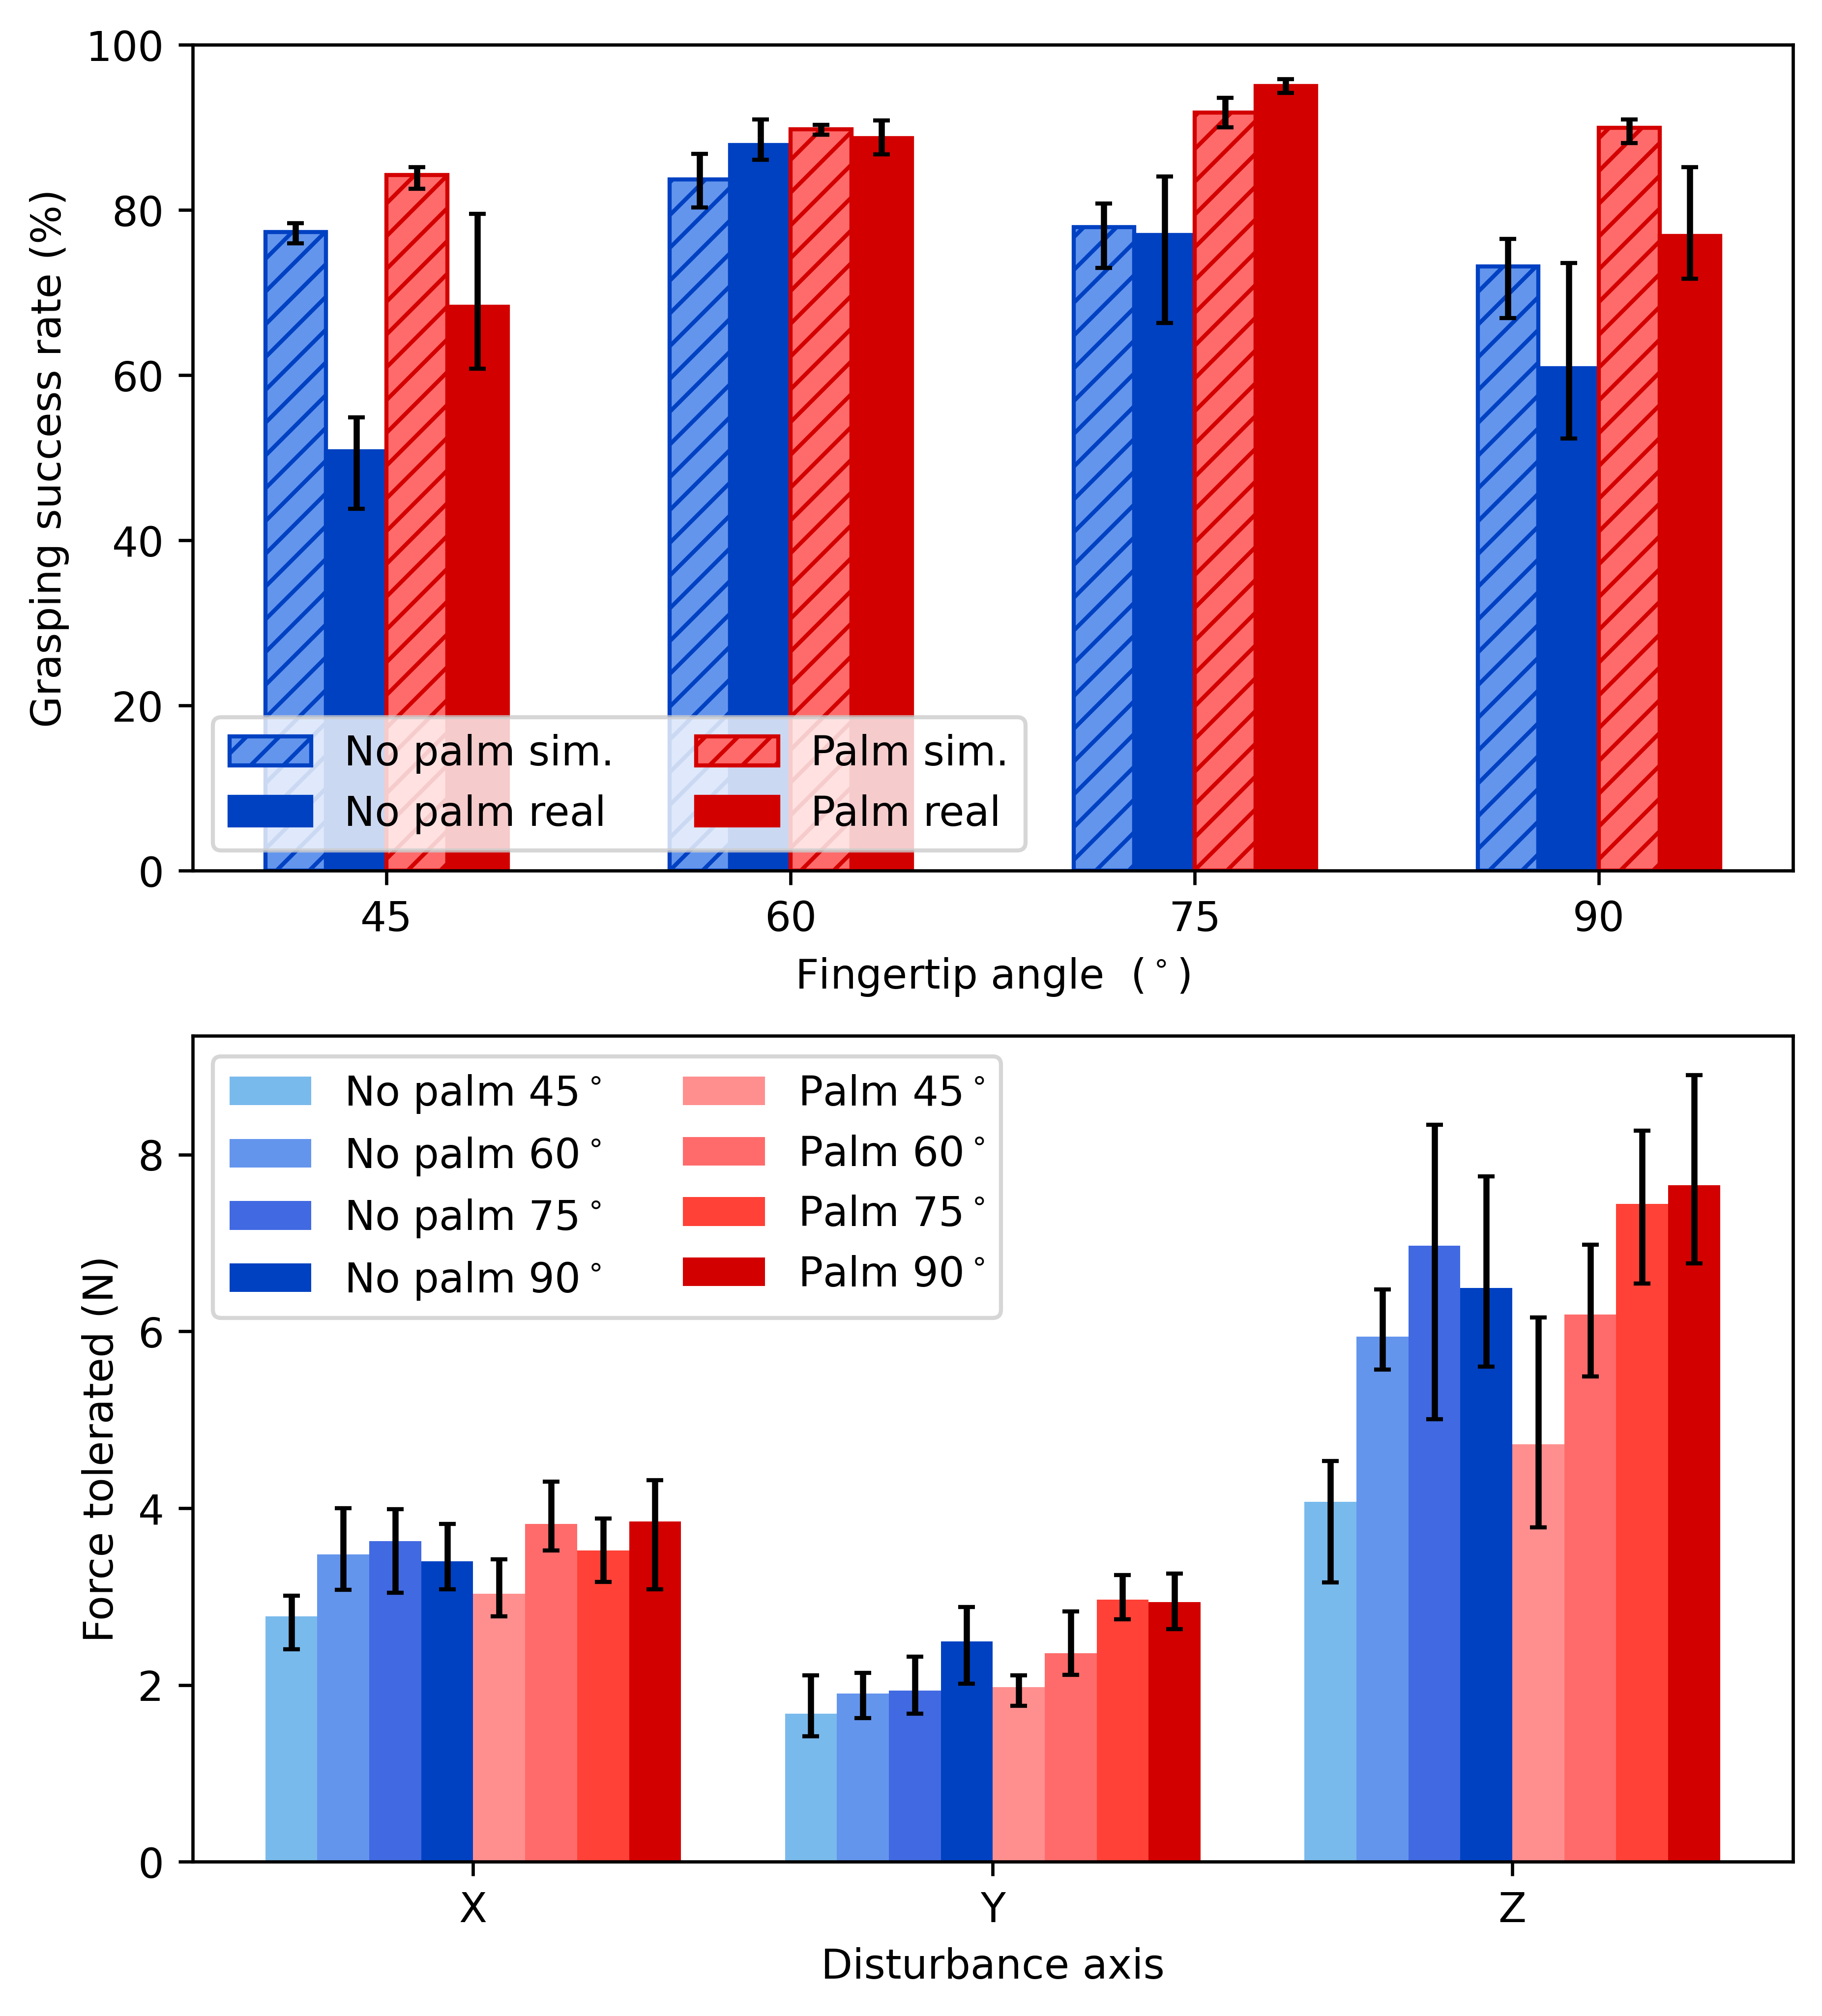

In [50]:
fig, axs = plt.subplots(2, 1)

angles = ["45", "60", "75", "90"]
label_locations = np.arange(len(angles))

x_axis = ["X", "Y", "Z"]
label_locations_2 = np.arange(len(x_axis))

# for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):

colours = ["#6495ED", "#0041C2",
           "#FF6B6B", "#D30000"]
patterns = ["///", "", "///", ""]
edgecolours = ["#0041C2", "#0041C2", "#D30000", "#D30000"]
# edgecolours = ["#ffffff", "#6495ED", "#ffffff", "#FF6B6B"]

colours_2 = ["#0041C2", "#4169E1", "#6495ED", "#79baec",
           "#D30000", "#ff4137", "#FF6B6B", "#ff8f8f"]

no_palm_45 = 100 * np.array([results[0][x][0].avg_SR_per_obj for x in range(3)])
no_palm_60 = 100 * np.array([results[0][x][1].avg_SR_per_obj for x in range(3)])
no_palm_75 = 100 * np.array([results[0][x][2].avg_SR_per_obj for x in range(3)])
no_palm_90 = 100 * np.array([results[0][x][3].avg_SR_per_obj for x in range(3)])
palm_45 = 100 * np.array([results[1][x][0].avg_SR_per_obj for x in range(3)])
palm_60 = 100 * np.array([results[1][x][1].avg_SR_per_obj for x in range(3)])
palm_75 = 100 * np.array([results[1][x][2].avg_SR_per_obj for x in range(3)])
palm_90 = 100 * np.array([results[1][x][3].avg_SR_per_obj for x in range(3)])
sim_no_palm_45 = 100 * np.array([results[0][x][0].sim_SR for x in range(3)])
sim_no_palm_60 = 100 * np.array([results[0][x][1].sim_SR for x in range(3)])
sim_no_palm_75 = 100 * np.array([results[0][x][2].sim_SR for x in range(3)])
sim_no_palm_90 = 100 * np.array([results[0][x][3].sim_SR for x in range(3)])
sim_palm_45 = 100 * np.array([results[1][x][0].sim_SR for x in range(3)])
sim_palm_60 = 100 * np.array([results[1][x][1].sim_SR for x in range(3)])
sim_palm_75 = 100 * np.array([results[1][x][2].sim_SR for x in range(3)])
sim_palm_90 = 100 * np.array([results[1][x][3].sim_SR for x in range(3)])

width = 0.15
multiplier = -0.5

# bar chart data
rates = {
  "No palm sim." : (
      sim_no_palm_45,
      sim_no_palm_60,
      sim_no_palm_75,
      sim_no_palm_90,
  ),
  "No palm real" : (
      no_palm_45,
      no_palm_60,
      no_palm_75,
      no_palm_90,
  ),
  "Palm sim." : (
      sim_palm_45,
      sim_palm_60,
      sim_palm_75,
      sim_palm_90,
  ),
  "Palm real" : (
      palm_45,
      palm_60,
      palm_75,
      palm_90,
  ),
}

for ijk, (attribute, measurement) in enumerate(rates.items()):
  avg = np.average(measurement, axis=1)
  yerr=(avg - np.min(measurement, axis=1), 
        np.max(measurement, axis=1) - avg)
  offset = width * multiplier
  rects = axs[0].bar(label_locations + offset, avg, width, label=attribute, yerr=yerr,
                  capsize=2,  color=colours[ijk], hatch=patterns[ijk], edgecolor=edgecolours[ijk])
  # axs.bar_label(rects, padding=-15, fmt="%.2f")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_xlabel("Fingertip angle  ($^\circ$)")
axs[0].set_ylabel("Grasping success rate (%)")
# axs[0].set_title("Grasp success rate across finger stiffnesses")
axs[0].set_xticks(label_locations + width, angles)
axs[0].legend(loc="lower left", ncols=2)
axs[0].set_ylim(0, 100)

# ----- 2nd bar chart ----- #

x_axis = ["X", "Y", "Z"]
label_locations = np.arange(len(x_axis))

# for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):

colours = ["#79baec", "#6495ED", "#4169E1", "#0041C2",
           "#ff8f8f", "#FF6B6B", "#ff4137", "#D30000"]
patterns = ["", "///", "", "///"]
edgecolours = ["#0041C2", "#0041C2",
               "#D30000", "#D30000"]

no_palm_45_x = np.array([results[0][x][0].avg_X_frc_saturated for x in range(3)])
no_palm_60_x = np.array([results[0][x][1].avg_X_frc_saturated for x in range(3)])
no_palm_75_x = np.array([results[0][x][2].avg_X_frc_saturated for x in range(3)])
no_palm_90_x = np.array([results[0][x][3].avg_X_frc_saturated for x in range(3)])
no_palm_45_y = np.array([results[0][x][0].avg_Y_frc_saturated for x in range(3)])
no_palm_60_y = np.array([results[0][x][1].avg_Y_frc_saturated for x in range(3)])
no_palm_75_y = np.array([results[0][x][2].avg_Y_frc_saturated for x in range(3)])
no_palm_90_y = np.array([results[0][x][3].avg_Y_frc_saturated for x in range(3)])
no_palm_45_z = np.array([results[0][x][0].avg_palm_frc_saturated for x in range(3)])
no_palm_60_z = np.array([results[0][x][1].avg_palm_frc_saturated for x in range(3)])
no_palm_75_z = np.array([results[0][x][2].avg_palm_frc_saturated for x in range(3)])
no_palm_90_z = np.array([results[0][x][3].avg_palm_frc_saturated for x in range(3)])

palm_45_x = np.array([results[1][x][0].avg_X_frc_saturated for x in range(3)])
palm_60_x = np.array([results[1][x][1].avg_X_frc_saturated for x in range(3)])
palm_75_x = np.array([results[1][x][2].avg_X_frc_saturated for x in range(3)])
palm_90_x = np.array([results[1][x][3].avg_X_frc_saturated for x in range(3)])
palm_45_y = np.array([results[1][x][0].avg_Y_frc_saturated for x in range(3)])
palm_60_y = np.array([results[1][x][1].avg_Y_frc_saturated for x in range(3)])
palm_75_y = np.array([results[1][x][2].avg_Y_frc_saturated for x in range(3)])
palm_90_y = np.array([results[1][x][3].avg_Y_frc_saturated for x in range(3)])
palm_45_z = np.array([results[1][x][0].avg_palm_frc_saturated for x in range(3)])
palm_60_z = np.array([results[1][x][1].avg_palm_frc_saturated for x in range(3)])
palm_75_z = np.array([results[1][x][2].avg_palm_frc_saturated for x in range(3)])
palm_90_z = np.array([results[1][x][3].avg_palm_frc_saturated for x in range(3)])


width = 0.1
multiplier = -2.5

rates = {
  "No palm 45$^\circ$" : (
      no_palm_45_x,
      no_palm_45_y,
      no_palm_45_z,
  ),
  "No palm 60$^\circ$" : (
      no_palm_60_x,
      no_palm_60_y,
      no_palm_60_z,
  ),
  "No palm 75$^\circ$" : (
      no_palm_75_x,
      no_palm_75_y,
      no_palm_75_z,
  ),
  "No palm 90$^\circ$" : (
      no_palm_90_x,
      no_palm_90_y,
      no_palm_90_z,
  ),
  "Palm 45$^\circ$" : (
      palm_45_x,
      palm_45_y,
      palm_45_z,
  ),
  "Palm 60$^\circ$" : (
      palm_60_x,
      palm_60_y,
      palm_60_z,
  ),
  "Palm 75$^\circ$" : (
      palm_75_x,
      palm_75_y,
      palm_75_z,
  ),
  "Palm 90$^\circ$" : (
      palm_90_x,
      palm_90_y,
      palm_90_z,
  ),
}

for ijk, (attribute, measurement) in enumerate(rates.items()):

  avg = np.average(measurement, axis=1)
  yerr=(avg - np.min(measurement, axis=1), 
        np.max(measurement, axis=1) - avg)
  offset = width * multiplier
  rects = axs[1].bar(label_locations + offset, avg, width, label=attribute, yerr=yerr,
                  capsize=2,  color=colours[ijk])
                  # , hatch=patterns[ijk], edgecolor=edgecolours[ijk])
  # axs.bar_label(rects, padding=-15, fmt="%.2f")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_xlabel("Disturbance axis")
axs[1].set_ylabel("Force tolerated (N)")
# axs[1].set_title("Grasp success rate across finger stiffnesses")
axs[1].set_xticks(label_locations + width, x_axis)
axs[1].legend(loc="upper left", ncols=2)
# axs[1].set_ylim(0, 8)

fig.set_size_inches(7, 8)

name = "success and force bar chart"
fig.savefig(f"/home/luke/Pictures/IROS figures/{name}.png")

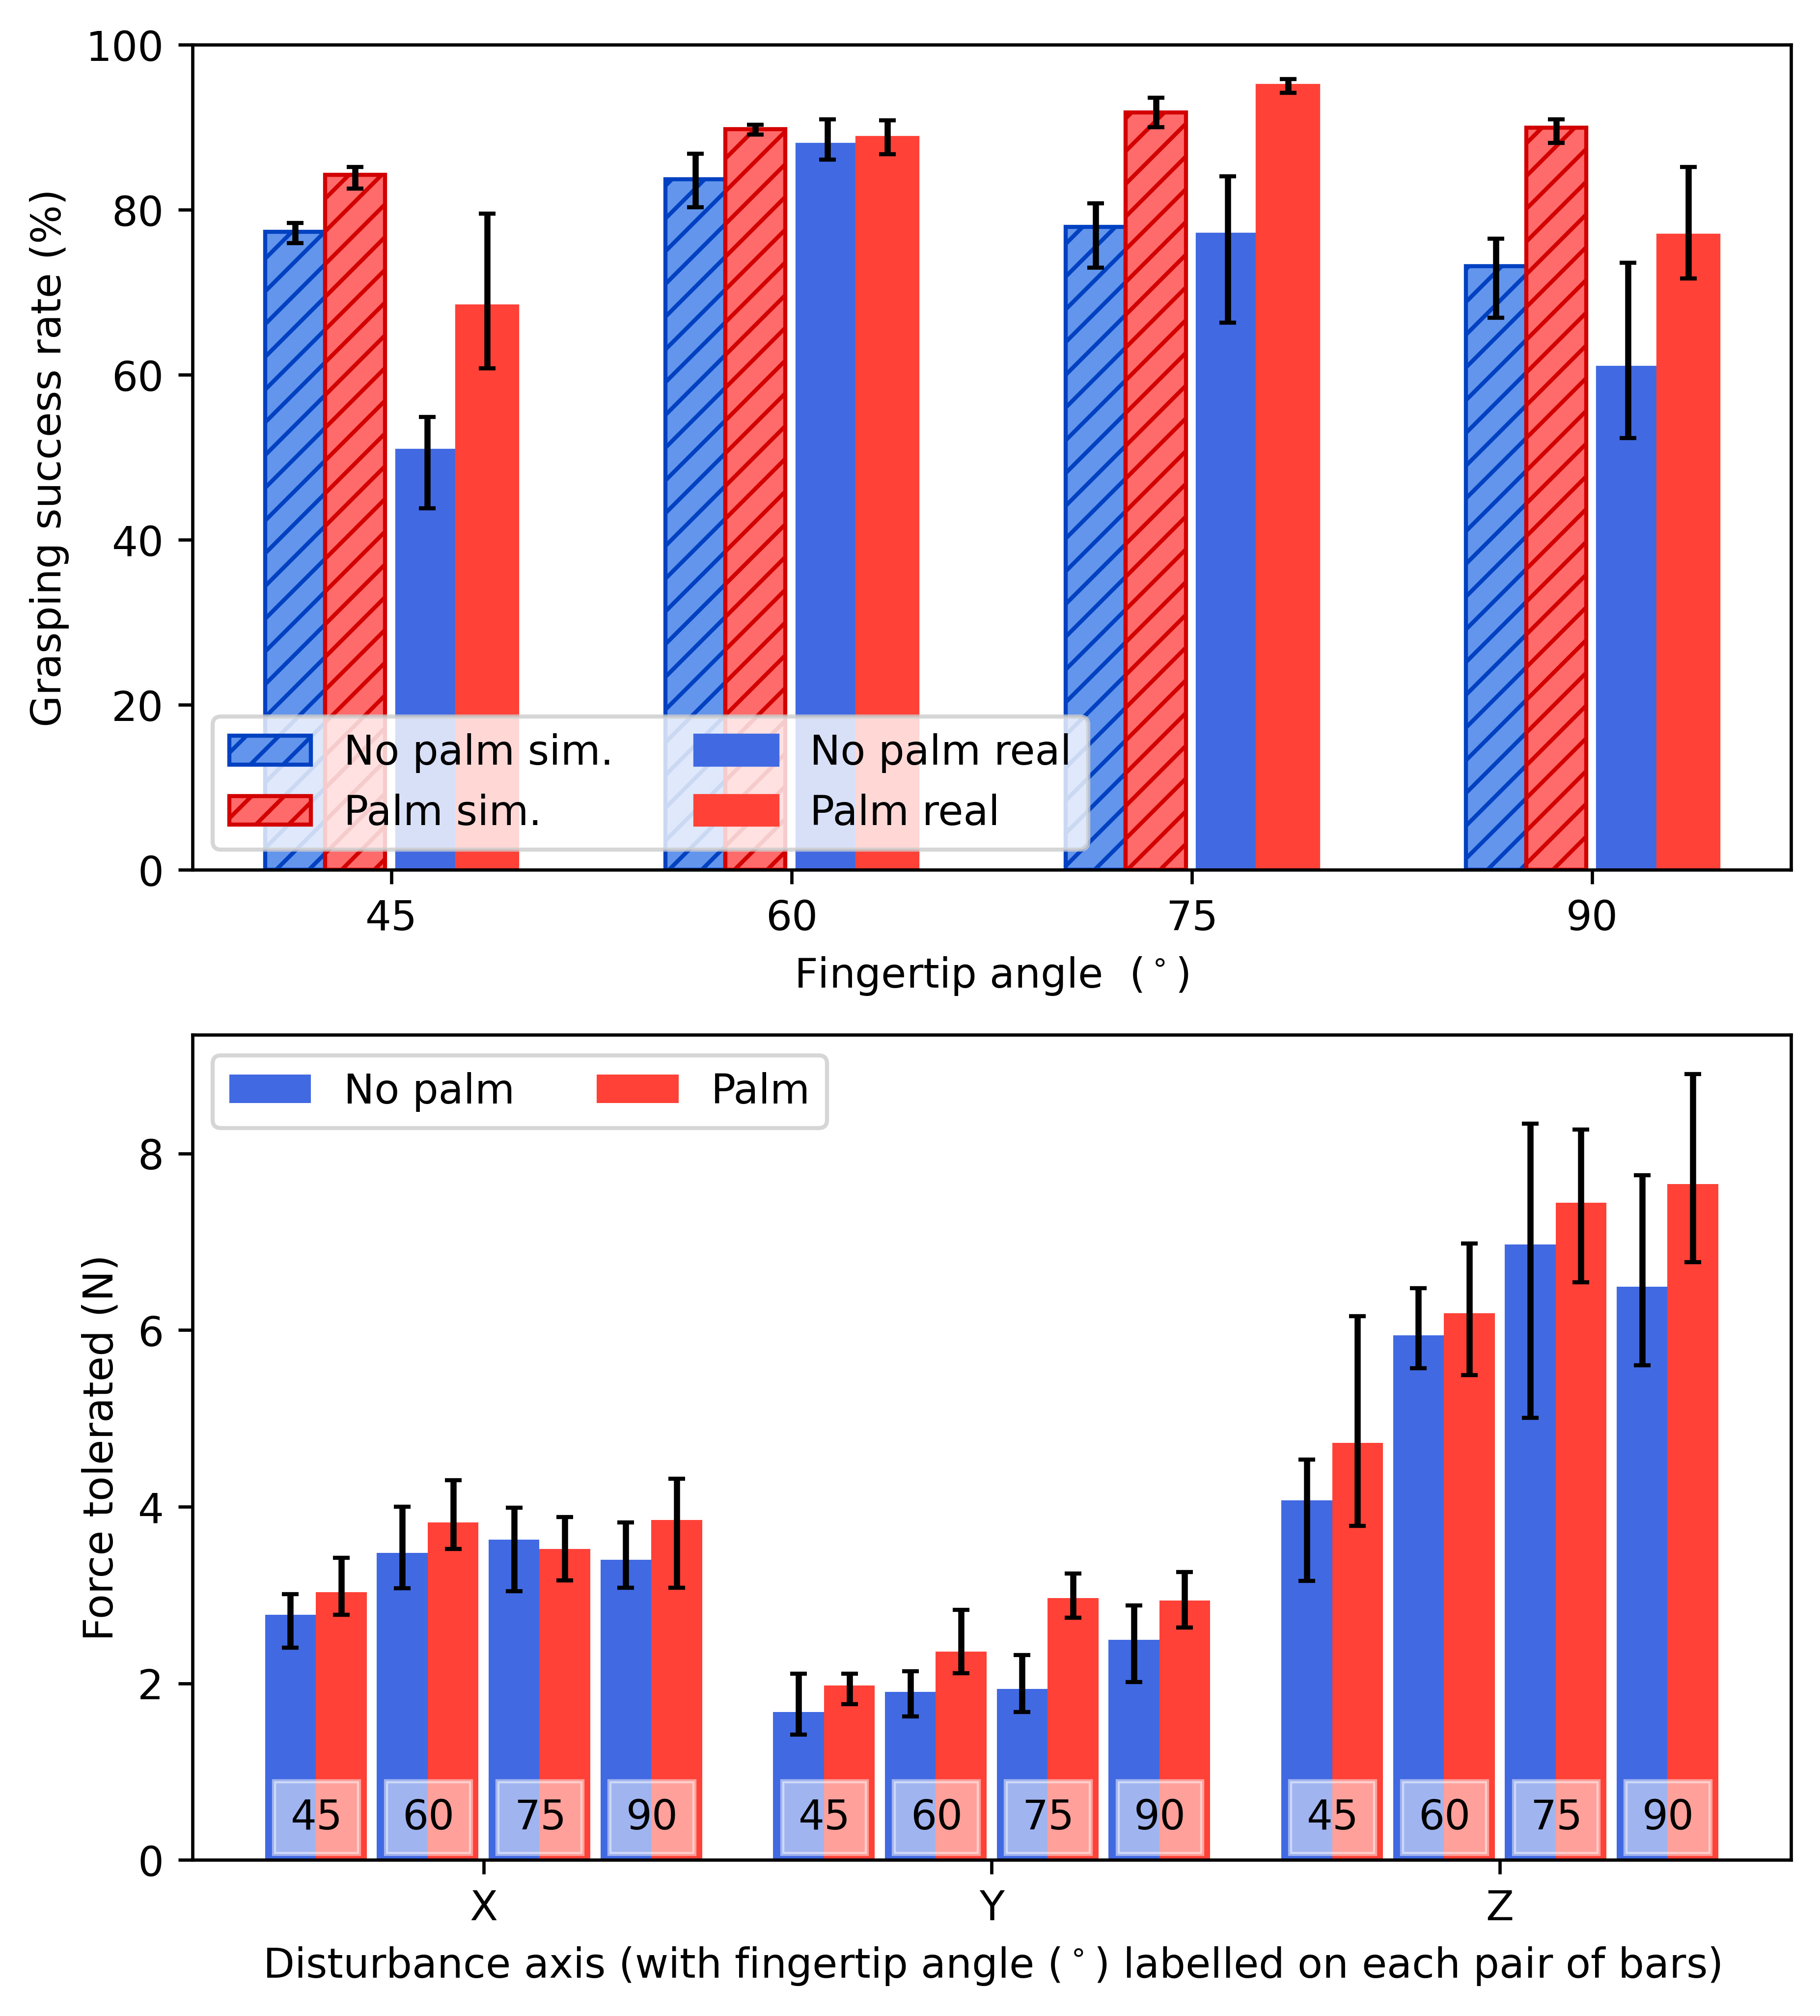

In [51]:
fig, axs = plt.subplots(2, 1)

angles = ["45", "60", "75", "90"]
label_locations = np.arange(len(angles))

x_axis = ["X", "Y", "Z"]
label_locations_2 = np.arange(len(x_axis))

# for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):

colours = ["#6495ED", "#FF6B6B", "#4169E1", "#ff4137"]
# colours = ["#4169E1", "#ff4137", "#4169E1", "#ff4137"]

patterns = ["///", "///", "", "",]
edgecolours = ["#0041C2", "#D30000", "#4169E1", "#ff4137"]

no_palm_45 = 100 * np.array([results[0][x][0].avg_SR_per_obj for x in range(3)])
no_palm_60 = 100 * np.array([results[0][x][1].avg_SR_per_obj for x in range(3)])
no_palm_75 = 100 * np.array([results[0][x][2].avg_SR_per_obj for x in range(3)])
no_palm_90 = 100 * np.array([results[0][x][3].avg_SR_per_obj for x in range(3)])
palm_45 = 100 * np.array([results[1][x][0].avg_SR_per_obj for x in range(3)])
palm_60 = 100 * np.array([results[1][x][1].avg_SR_per_obj for x in range(3)])
palm_75 = 100 * np.array([results[1][x][2].avg_SR_per_obj for x in range(3)])
palm_90 = 100 * np.array([results[1][x][3].avg_SR_per_obj for x in range(3)])
sim_no_palm_45 = 100 * np.array([results[0][x][0].sim_SR for x in range(3)])
sim_no_palm_60 = 100 * np.array([results[0][x][1].sim_SR for x in range(3)])
sim_no_palm_75 = 100 * np.array([results[0][x][2].sim_SR for x in range(3)])
sim_no_palm_90 = 100 * np.array([results[0][x][3].sim_SR for x in range(3)])
sim_palm_45 = 100 * np.array([results[1][x][0].sim_SR for x in range(3)])
sim_palm_60 = 100 * np.array([results[1][x][1].sim_SR for x in range(3)])
sim_palm_75 = 100 * np.array([results[1][x][2].sim_SR for x in range(3)])
sim_palm_90 = 100 * np.array([results[1][x][3].sim_SR for x in range(3)])

width = 0.15
gap = width * 0.2
multiplier = -0.5

# bar chart data
rates = {
  "No palm sim." : (
      sim_no_palm_45,
      sim_no_palm_60,
      sim_no_palm_75,
      sim_no_palm_90,
  ),
  "Palm sim." : (
      sim_palm_45,
      sim_palm_60,
      sim_palm_75,
      sim_palm_90,
  ),
  "No palm real" : (
      no_palm_45,
      no_palm_60,
      no_palm_75,
      no_palm_90,
  ),
  "Palm real" : (
      palm_45,
      palm_60,
      palm_75,
      palm_90,
  ),
}

for ijk, (attribute, measurement) in enumerate(rates.items()):

  avg = np.average(measurement, axis=1)
  yerr=(avg - np.min(measurement, axis=1), 
        np.max(measurement, axis=1) - avg)

  offset = width * multiplier + gap * (ijk % 2 == 0)
  bar_num = ijk % 4
  if bar_num in [0]: bar_shift = -gap*1
  elif bar_num in [1, 2]: bar_shift = -gap*0
  elif bar_num in [3]: bar_shift = gap*1
  offset += bar_shift

  rects = axs[0].bar(label_locations + offset - (gap/2), avg, width, label=attribute, yerr=yerr,
                  capsize=2,  color=colours[ijk], hatch=patterns[ijk], edgecolor=edgecolours[ijk])
  # axs.bar_label(rects, padding=-15, fmt="%.2f")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_xlabel("Fingertip angle  ($^\circ$)")
axs[0].set_ylabel("Grasping success rate (%)")
# axs[0].set_title("Grasp success rate across finger stiffnesses")
axs[0].set_xticks(label_locations + width, angles)
axs[0].legend(loc="lower left", ncols=2)
axs[0].set_ylim(0, 100)

# ----- 2nd bar chart ----- #

x_axis = ["X", "Y", "Z"]
label_locations = np.arange(len(x_axis))

# for j in range(len(stiffnesses)):
  # for k in range(len(fingers)):
    # for i in range(len(palms)):
        
colours = ["#79baec", "#ff8f8f", "#6495ED", "#FF6B6B", 
           "#4169E1", "#ff4137", "#0041C2", "#D30000"]

colours = ["#4169E1", "#ff4137", "#4169E1", "#ff4137", 
           "#4169E1", "#ff4137", "#4169E1", "#ff4137"]
  
patterns = ["", "///", "", "///"]
edgecolours = ["#0041C2", "#0041C2",
               "#D30000", "#D30000"]

no_palm_45_x = np.array([results[0][x][0].avg_X_frc_saturated for x in range(3)])
no_palm_60_x = np.array([results[0][x][1].avg_X_frc_saturated for x in range(3)])
no_palm_75_x = np.array([results[0][x][2].avg_X_frc_saturated for x in range(3)])
no_palm_90_x = np.array([results[0][x][3].avg_X_frc_saturated for x in range(3)])
no_palm_45_y = np.array([results[0][x][0].avg_Y_frc_saturated for x in range(3)])
no_palm_60_y = np.array([results[0][x][1].avg_Y_frc_saturated for x in range(3)])
no_palm_75_y = np.array([results[0][x][2].avg_Y_frc_saturated for x in range(3)])
no_palm_90_y = np.array([results[0][x][3].avg_Y_frc_saturated for x in range(3)])
no_palm_45_z = np.array([results[0][x][0].avg_palm_frc_saturated for x in range(3)])
no_palm_60_z = np.array([results[0][x][1].avg_palm_frc_saturated for x in range(3)])
no_palm_75_z = np.array([results[0][x][2].avg_palm_frc_saturated for x in range(3)])
no_palm_90_z = np.array([results[0][x][3].avg_palm_frc_saturated for x in range(3)])

palm_45_x = np.array([results[1][x][0].avg_X_frc_saturated for x in range(3)])
palm_60_x = np.array([results[1][x][1].avg_X_frc_saturated for x in range(3)])
palm_75_x = np.array([results[1][x][2].avg_X_frc_saturated for x in range(3)])
palm_90_x = np.array([results[1][x][3].avg_X_frc_saturated for x in range(3)])
palm_45_y = np.array([results[1][x][0].avg_Y_frc_saturated for x in range(3)])
palm_60_y = np.array([results[1][x][1].avg_Y_frc_saturated for x in range(3)])
palm_75_y = np.array([results[1][x][2].avg_Y_frc_saturated for x in range(3)])
palm_90_y = np.array([results[1][x][3].avg_Y_frc_saturated for x in range(3)])
palm_45_z = np.array([results[1][x][0].avg_palm_frc_saturated for x in range(3)])
palm_60_z = np.array([results[1][x][1].avg_palm_frc_saturated for x in range(3)])
palm_75_z = np.array([results[1][x][2].avg_palm_frc_saturated for x in range(3)])
palm_90_z = np.array([results[1][x][3].avg_palm_frc_saturated for x in range(3)])


width = 0.1
gap = width * 0.2
multiplier = -2.5

rates = {
  "No palm 45$^\circ$" : (
      no_palm_45_x,
      no_palm_45_y,
      no_palm_45_z,
  ),
  "Palm 45$^\circ$" : (
      palm_45_x,
      palm_45_y,
      palm_45_z,
  ),
  "No palm 60$^\circ$" : (
      no_palm_60_x,
      no_palm_60_y,
      no_palm_60_z,
  ),
  "Palm 60$^\circ$" : (
      palm_60_x,
      palm_60_y,
      palm_60_z,
  ),
  "No palm 75$^\circ$" : (
      no_palm_75_x,
      no_palm_75_y,
      no_palm_75_z,
  ),
  "Palm 75$^\circ$" : (
      palm_75_x,
      palm_75_y,
      palm_75_z,
  ),
  "No palm 90$^\circ$" : (
      no_palm_90_x,
      no_palm_90_y,
      no_palm_90_z,
  ),
  "Palm 90$^\circ$" : (
      palm_90_x,
      palm_90_y,
      palm_90_z,
  ),
}

for ijk, (attribute, measurement) in enumerate(rates.items()):

  avg = np.average(measurement, axis=1)
  yerr=(avg - np.min(measurement, axis=1), 
        np.max(measurement, axis=1) - avg)

  offset = width * multiplier + gap * (ijk % 2 == 0)
  bar_num = ijk % 8
  if bar_num in [0]: bar_shift = -gap*2
  elif bar_num in [1, 2]: bar_shift = -gap*1
  elif bar_num in [3, 4]: bar_shift = gap*0
  elif bar_num in [5, 6]: bar_shift = gap*1
  elif bar_num in [7]: bar_shift = gap*2
  offset += bar_shift

  if ijk == 0: label = "No palm"
  elif ijk == 1: label = "Palm"
  else: label = None
  # label = attribute
  rects = axs[1].bar(label_locations + offset - (gap/2), avg, width, label=label, yerr=yerr,
                  capsize=2,  color=colours[ijk])
                  # , hatch=patterns[ijk], edgecolor=edgecolours[ijk])

  if ijk % 2 == 0:
    angle_name = fingers[int(ijk * 0.5)]
    axs[1].text(label_locations[0] + offset - (gap/2), 0.35, angle_name, backgroundcolor=(1,1,1,0.5))
    axs[1].text(label_locations[1] + offset - (gap/2), 0.35, angle_name, backgroundcolor=(1,1,1,0.5))
    axs[1].text(label_locations[2] + offset - (gap/2), 0.35, angle_name, backgroundcolor=(1,1,1,0.5))

  multiplier += 1

# for loop in range(3):
#     for bar in range(len(fingers)):
#         offset = width * multiplier
#         bar_num = bar * 2
#         if bar_num in [0]: bar_shift = -gap*2
#         elif bar_num in [1, 2]: bar_shift = -gap*1
#         elif bar_num in [3, 4]: bar_shift = gap*0
#         elif bar_num in [5, 6]: bar_shift = gap*1
#         elif bar_num in [7]: bar_shift = gap*2
#         offset += bar_shift
#         txt_x = -width + offset + label_locations[loop] - (barnum) * width * 0.25
#         axs[1].text(txt_x, 0.15, str(fingers[bar]))

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_xlabel("Disturbance axis (with fingertip angle ($^\circ$) labelled on each pair of bars)")
axs[1].set_ylabel("Force tolerated (N)")
# axs[1].set_title("Grasp success rate across finger stiffnesses")
axs[1].set_xticks(label_locations + width, x_axis)
axs[1].legend(loc="upper left", ncols=2)
# axs[1].set_ylim(0, 8)

fig.set_size_inches(7, 8)

name = "success and force bar chart alternating"
fig.savefig(f"/home/luke/Pictures/IROS figures/{name}.png")

In [52]:
# print out a table

A = palms
B = stiffnesses
C = fingers

if A == palms and B == stiffnesses:
  a = "use palm"
  b = "stiffness"
  c = "tip angle"
elif A == palms and B == fingers:
  a = "use palm"
  b = "tip angle"
  c = "stiffness"
elif A == stiffnesses and B == palms:
  a = "stiffness"
  b = "use palm"
  c = "tip angle"
elif A == stiffnesses and B == fingers:
  a = "stiffness"
  b = "tip angle"
  c = "use palm"
elif A == fingers and B == palms:
  a = "tip angle"
  b = "use palm"
  c = "stiffness"
elif A == fingers and B == stiffnesses:
  a = "tip angle"
  b = "stiffness"
  c = "use_palm"

headings = f"""{a:<10} | {b:<10} | {c:<10} | {"Sim %":<6} | {"Real %":<6} | {"X":<5} | {"Y":<5} | {"Z":<5} | {"numX":<5} | {"numY":<5} | {"numZ":<5} | {"trials":<6}"""
rows = "{0:<10} | {1:<10} | {2:<10} | {3:<6.2f} | {4:<6.2f} | {5:<5.2f} | {6:<5.2f} | {7:<5.2f} | {8:<5} | {9:<5} | {10:<5} | {11:<6}"

print(headings)

for i in range(len(A)):
  for j in range(len(B)):
    for k in range(len(C)):

      print(rows.format(
        A[i], B[j], C[k], results[i][j][k].sim_SR * 100, results[i][j][k].avg_SR_per_obj * 100,
        results[i][j][k].avg_X_frc_saturated, results[i][j][k].avg_Y_frc_saturated, results[i][j][k].avg_palm_frc_saturated,
        results[i][j][k].num_X_probe, results[i][j][k].num_Y_probe, results[i][j][k].num_Z_probe, results[i][j][k].num_trials
      ))




use palm   | stiffness  | tip angle  | Sim %  | Real % | X     | Y     | Z     | numX  | numY  | numZ  | trials
no_palm    | 1          | 45         | 77.60  | 53.62  | 3.01  | 2.11  | 4.52  | 17    | 15    | 14    | 98    
no_palm    | 1          | 60         | 86.80  | 86.11  | 4.00  | 2.14  | 5.57  | 17    | 17    | 17    | 63    
no_palm    | 1          | 75         | 80.80  | 80.57  | 3.05  | 1.80  | 5.01  | 18    | 17    | 16    | 70    
no_palm    | 1          | 90         | 76.20  | 52.35  | 3.29  | 2.88  | 6.12  | 14    | 16    | 11    | 89    
no_palm    | 2          | 45         | 76.00  | 54.92  | 2.40  | 1.50  | 4.53  | 18    | 16    | 14    | 95    
no_palm    | 2          | 60         | 84.00  | 90.99  | 3.35  | 1.94  | 5.78  | 18    | 18    | 18    | 63    
no_palm    | 2          | 75         | 80.00  | 84.09  | 3.84  | 1.68  | 7.56  | 18    | 17    | 18    | 69    
no_palm    | 2          | 90         | 76.50  | 56.59  | 3.08  | 2.01  | 5.60  | 12    | 13    | 11    |